In [4]:
# =============================================================================
# KIDNEY DISEASE COMPREHENSIVE ANALYSIS
# Following the Methodology: Dataset → EDA → Preprocessing → Train/Test Split 
# → Feature Selection → Data Balancing → ML/DL Models → Ensemble → Evaluation
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
from scipy import stats
from scipy.stats import chi2_contingency, f_oneway
import warnings
warnings.filterwarnings('ignore')

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.feature_selection import SelectKBest, f_classif, RFE, SelectFromModel
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                           roc_auc_score, confusion_matrix, classification_report, 
                           roc_curve, precision_recall_curve, ConfusionMatrixDisplay)
from sklearn.impute import SimpleImputer, KNNImputer
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN

# Deep Learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

# Additional Libraries
import xgboost as xgb
from lightgbm import LGBMClassifier
# import shap
import eli5
from eli5.lime import TextExplainer
import lime
import lime.lime_tabular

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("=== KIDNEY DISEASE COMPREHENSIVE ANALYSIS ===")
print("All libraries imported successfully!")

2025-07-14 12:47:56.508215: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-14 12:47:56.515017: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-14 12:47:56.532010: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752475676.558824  779594 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752475676.567343  779594 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752475676.588193  779594 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

=== KIDNEY DISEASE COMPREHENSIVE ANALYSIS ===
All libraries imported successfully!


In [23]:
# =============================================================================
# STEP 1: DATASET LOADING AND INITIAL EXPLORATION
# =============================================================================

# Load the dataset
df = pd.read_csv('kidney_disease.csv')

print("=== DATASET OVERVIEW ===")
print(f"Dataset Shape: {df.shape}")
print(f"Number of Features: {df.shape[1]}")
print(f"Number of Samples: {df.shape[0]}")
print("\nFirst 5 rows:")
print(df.head())

print("\n=== DATASET INFO ===")
print(df.info())

print("\n=== FEATURE TYPE ANALYSIS ===")
print("=" * 50)

# Analyze data types
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

print(f"Number of Numeric Features: {len(numeric_features)}")
print(f"Number of Categorical Features: {len(categorical_features)}")
print(f"Total Features: {len(numeric_features) + len(categorical_features)}")

print(f"\nNumeric Features ({len(numeric_features)}):")
for i, feature in enumerate(numeric_features, 1):
    print(f"  {i}. {feature}")

print(f"\nCategorical Features ({len(categorical_features)}):")
for i, feature in enumerate(categorical_features, 1):
    print(f"  {i}. {feature}")

# Check if target variable is in the right category
if 'classification' in categorical_features:
    print(f"\n✓ Target variable 'classification' is correctly identified as categorical")
else:
    print(f"\n⚠ Target variable 'classification' is not in categorical features")

print("\n=== BASIC STATISTICS ===")
print(df.describe())

print("\n=== MISSING VALUES ANALYSIS ===")
missing_data = df.isnull().sum()
missing_percentage = (missing_data / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Values': missing_data,
    'Percentage': missing_percentage
})
print(missing_df[missing_df['Missing Values'] > 0].sort_values('Missing Values', ascending=False))

print("\n=== TARGET VARIABLE DISTRIBUTION ===")
print(df['classification'].value_counts())
print(f"\nTarget Distribution (%):")
print(df['classification'].value_counts(normalize=True) * 100)

# Additional analysis for categorical features
print("\n=== CATEGORICAL FEATURES DETAILED ANALYSIS ===")
print("=" * 50)

for feature in categorical_features:
    print(f"\n{feature}:")
    value_counts = df[feature].value_counts()
    print(f"  Unique values: {len(value_counts)}")
    print(f"  Values: {list(value_counts.index)}")
    print(f"  Counts: {list(value_counts.values)}")
    if df[feature].isnull().sum() > 0:
        print(f"  Missing values: {df[feature].isnull().sum()}")

# Additional analysis for numeric features
print("\n=== NUMERIC FEATURES DETAILED ANALYSIS ===")
print("=" * 50)

for feature in numeric_features:
    print(f"\n{feature}:")
    print(f"  Min: {df[feature].min():.2f}")
    print(f"  Max: {df[feature].max():.2f}")
    print(f"  Mean: {df[feature].mean():.2f}")
    print(f"  Median: {df[feature].median():.2f}")
    print(f"  Std: {df[feature].std():.2f}")
    if df[feature].isnull().sum() > 0:
        print(f"  Missing values: {df[feature].isnull().sum()}")

=== DATASET OVERVIEW ===
Dataset Shape: (400, 26)
Number of Features: 26
Number of Samples: 400

First 5 rows:
   id   age    bp     sg   al   su     rbc        pc         pcc          ba  \
0   0  48.0  80.0  1.020  1.0  0.0     NaN    normal  notpresent  notpresent   
1   1   7.0  50.0  1.020  4.0  0.0     NaN    normal  notpresent  notpresent   
2   2  62.0  80.0  1.010  2.0  3.0  normal    normal  notpresent  notpresent   
3   3  48.0  70.0  1.005  4.0  0.0  normal  abnormal     present  notpresent   
4   4  51.0  80.0  1.010  2.0  0.0  normal    normal  notpresent  notpresent   

   ...  pcv    wc   rc  htn   dm  cad appet   pe  ane classification  
0  ...   44  7800  5.2  yes  yes   no  good   no   no            ckd  
1  ...   38  6000  NaN   no   no   no  good   no   no            ckd  
2  ...   31  7500  NaN   no  yes   no  poor   no  yes            ckd  
3  ...   32  6700  3.9  yes   no   no  poor  yes  yes            ckd  
4  ...   35  7300  4.6   no   no   no  good   no   no

=== COMPREHENSIVE EDA STARTED ===

1. DATA QUALITY ANALYSIS
Data Types:
id                  int64
age               float64
bp                float64
sg                float64
al                float64
su                float64
rbc                object
pc                 object
pcc                object
ba                 object
bgr               float64
bu                float64
sc                float64
sod               float64
pot               float64
hemo              float64
pcv                object
wc                 object
rc                 object
htn                object
dm                 object
cad                object
appet              object
pe                 object
ane                object
classification     object
dtype: object

Duplicate rows: 0

Categorical columns: ['rbc', 'pc', 'pcc', 'ba', 'pcv', 'wc', 'rc', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane', 'classification']

rbc unique values:
rbc
normal      201
abnormal     47
Name: count, dtype: int64

pc uniqu

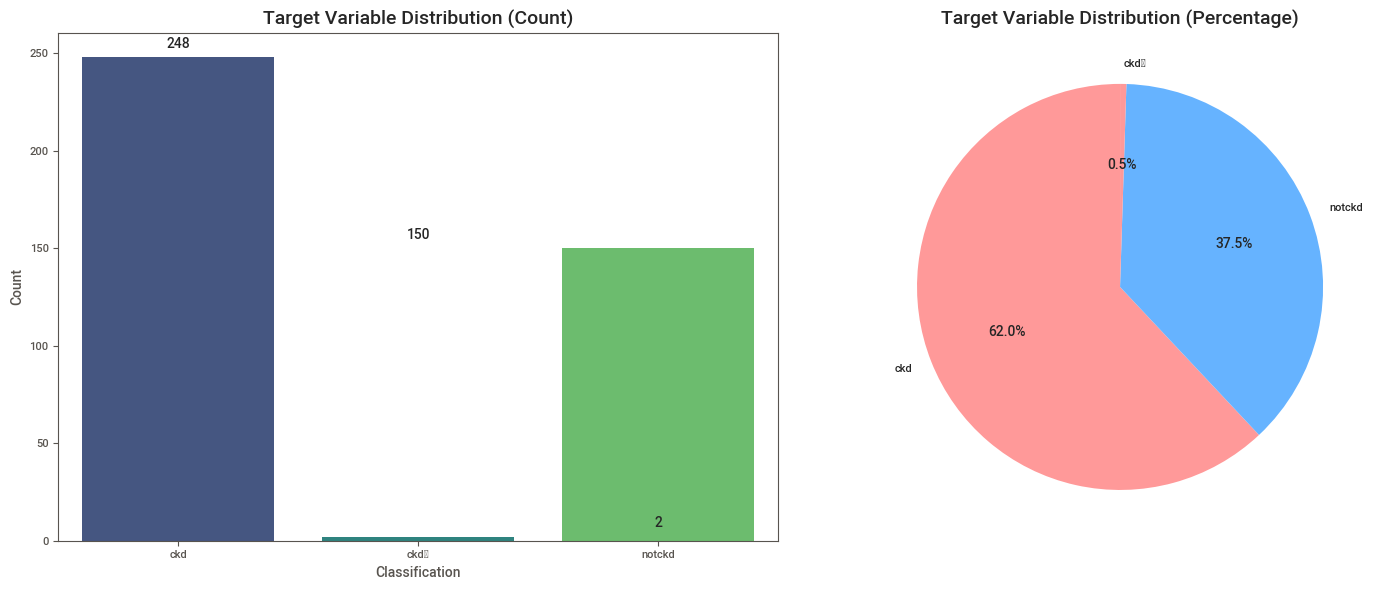


3. NUMERICAL FEATURES ANALYSIS
Numerical features: ['id', 'age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo']

Statistical Summary of Numerical Features:
               id         age          bp          sg          al          su  \
count  400.000000  391.000000  388.000000  353.000000  354.000000  351.000000   
mean   199.500000   51.483376   76.469072    1.017408    1.016949    0.450142   
std    115.614301   17.169714   13.683637    0.005717    1.352679    1.099191   
min      0.000000    2.000000   50.000000    1.005000    0.000000    0.000000   
25%     99.750000   42.000000   70.000000    1.010000    0.000000    0.000000   
50%    199.500000   55.000000   80.000000    1.020000    0.000000    0.000000   
75%    299.250000   64.500000   80.000000    1.020000    2.000000    0.000000   
max    399.000000   90.000000  180.000000    1.025000    5.000000    5.000000   

              bgr          bu          sc         sod         pot        hemo  
count  356.0000

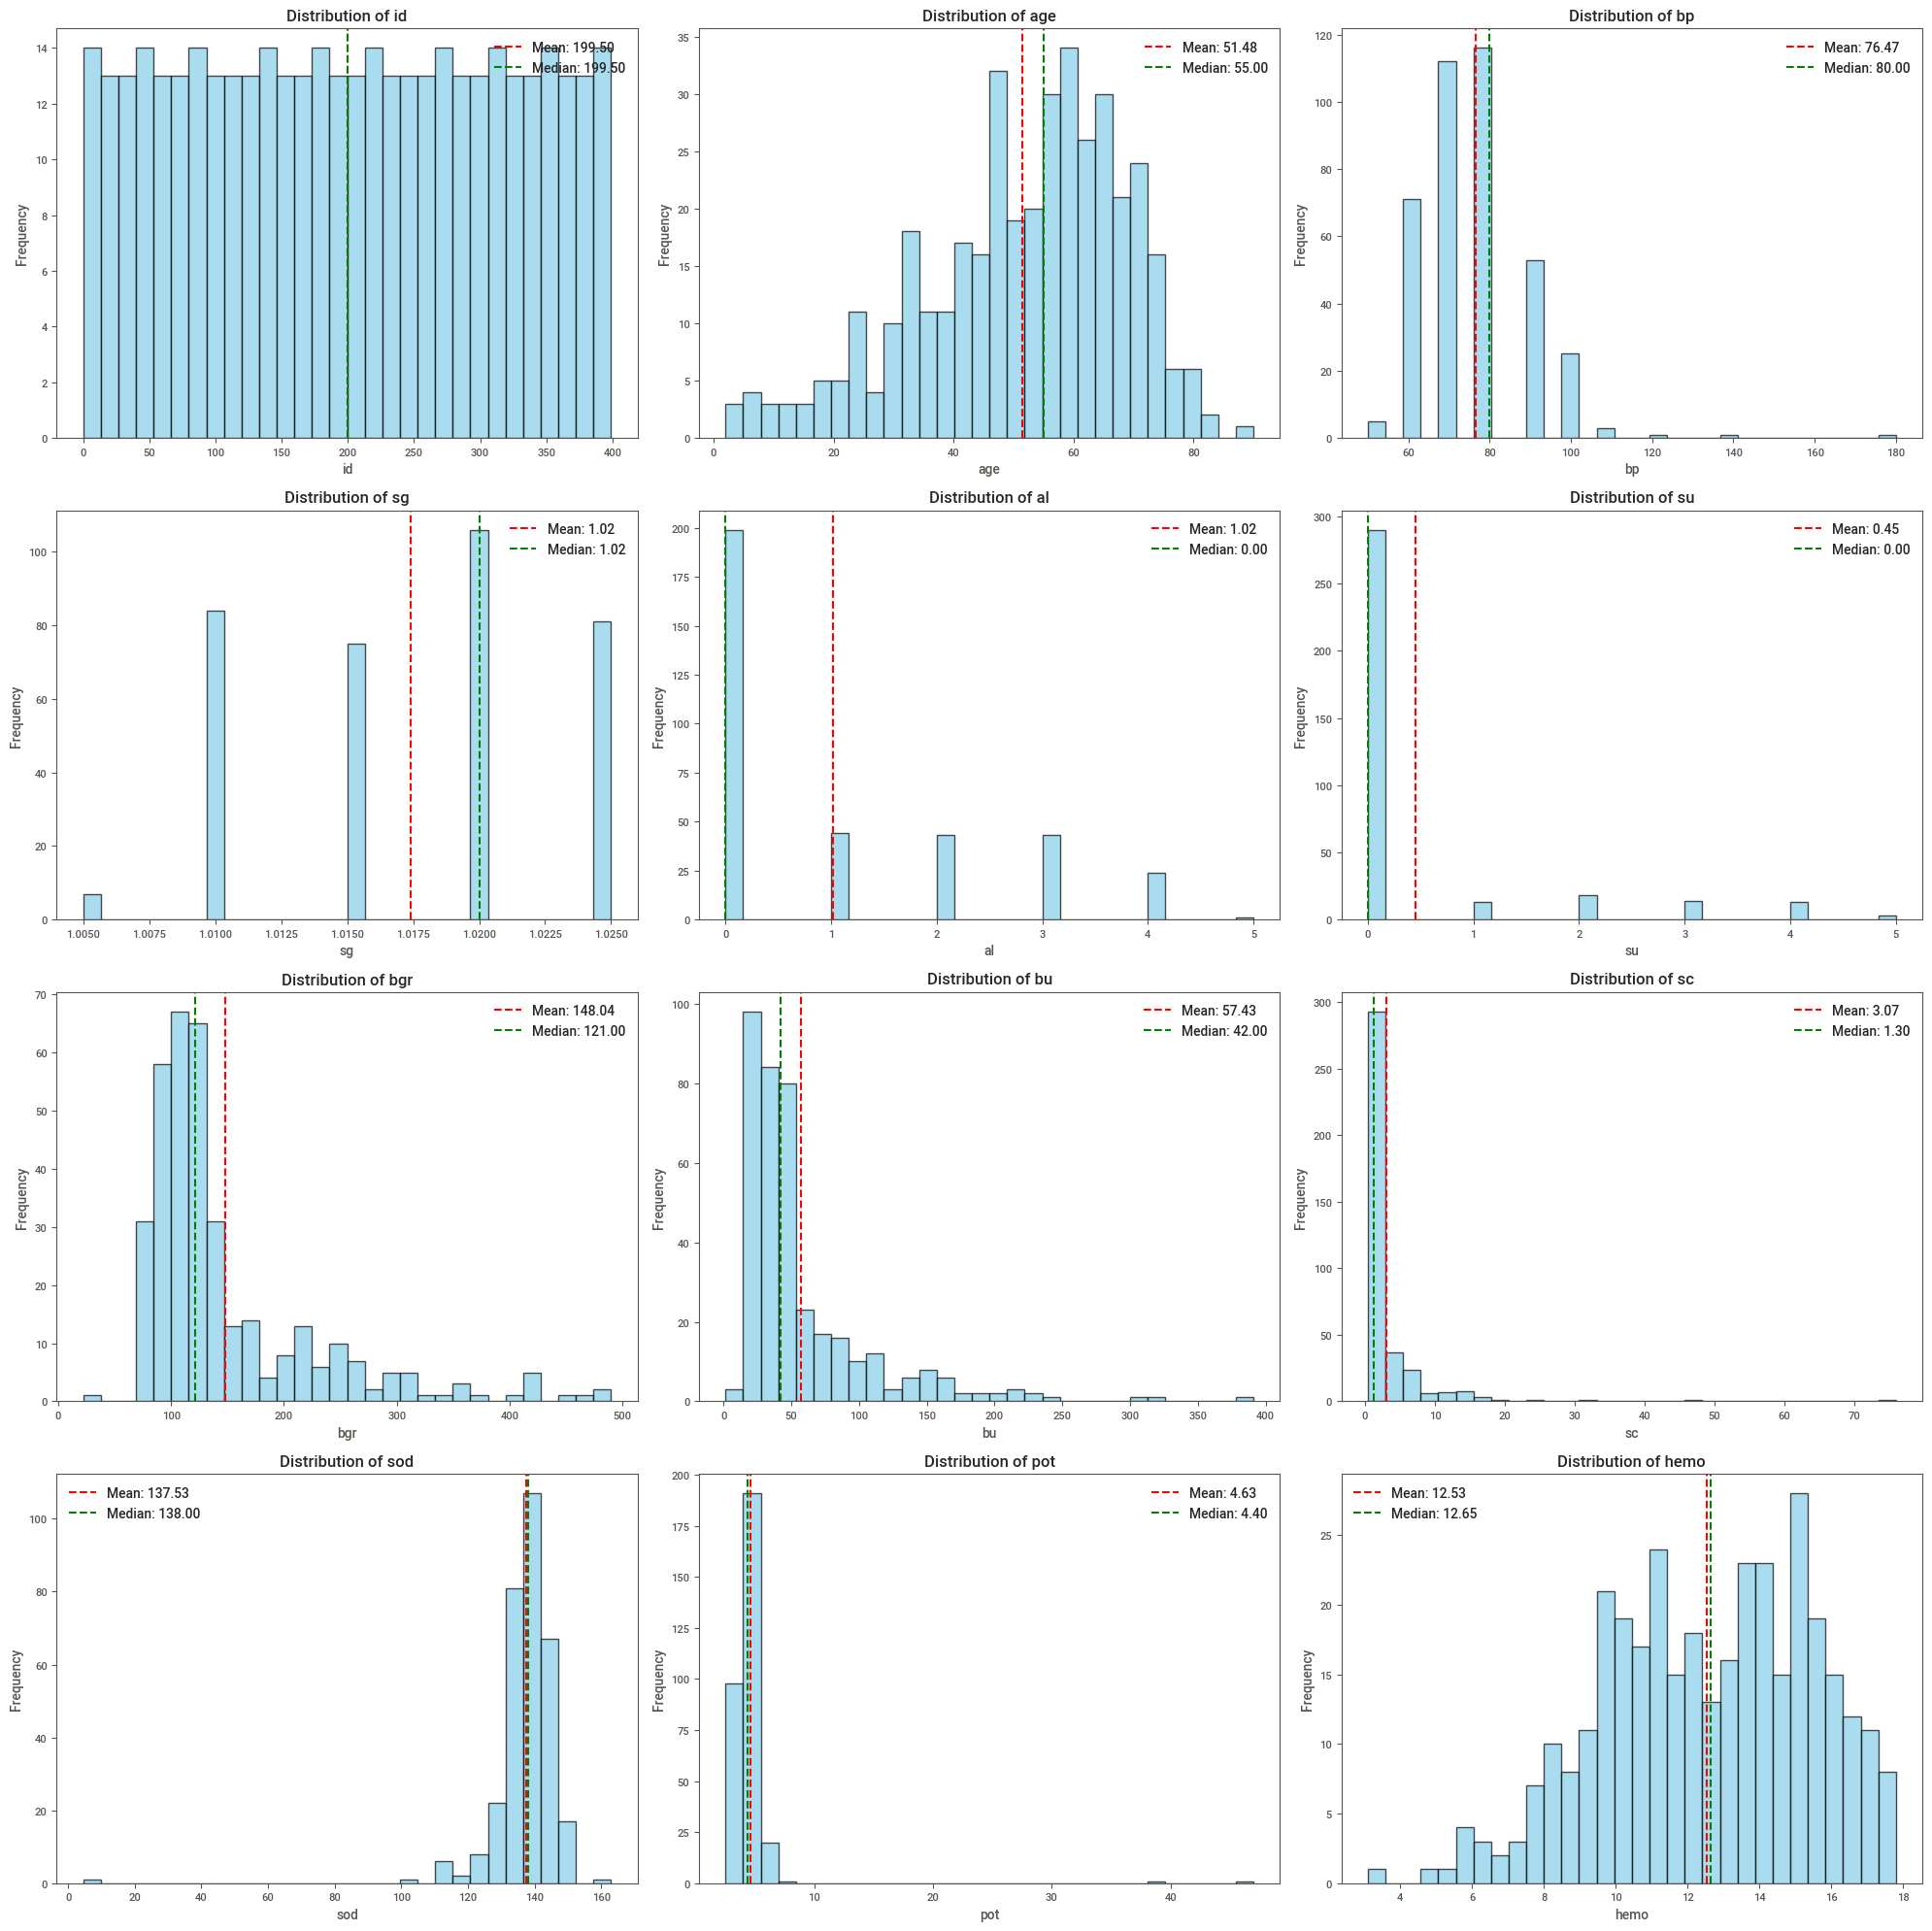


5. CORRELATION ANALYSIS


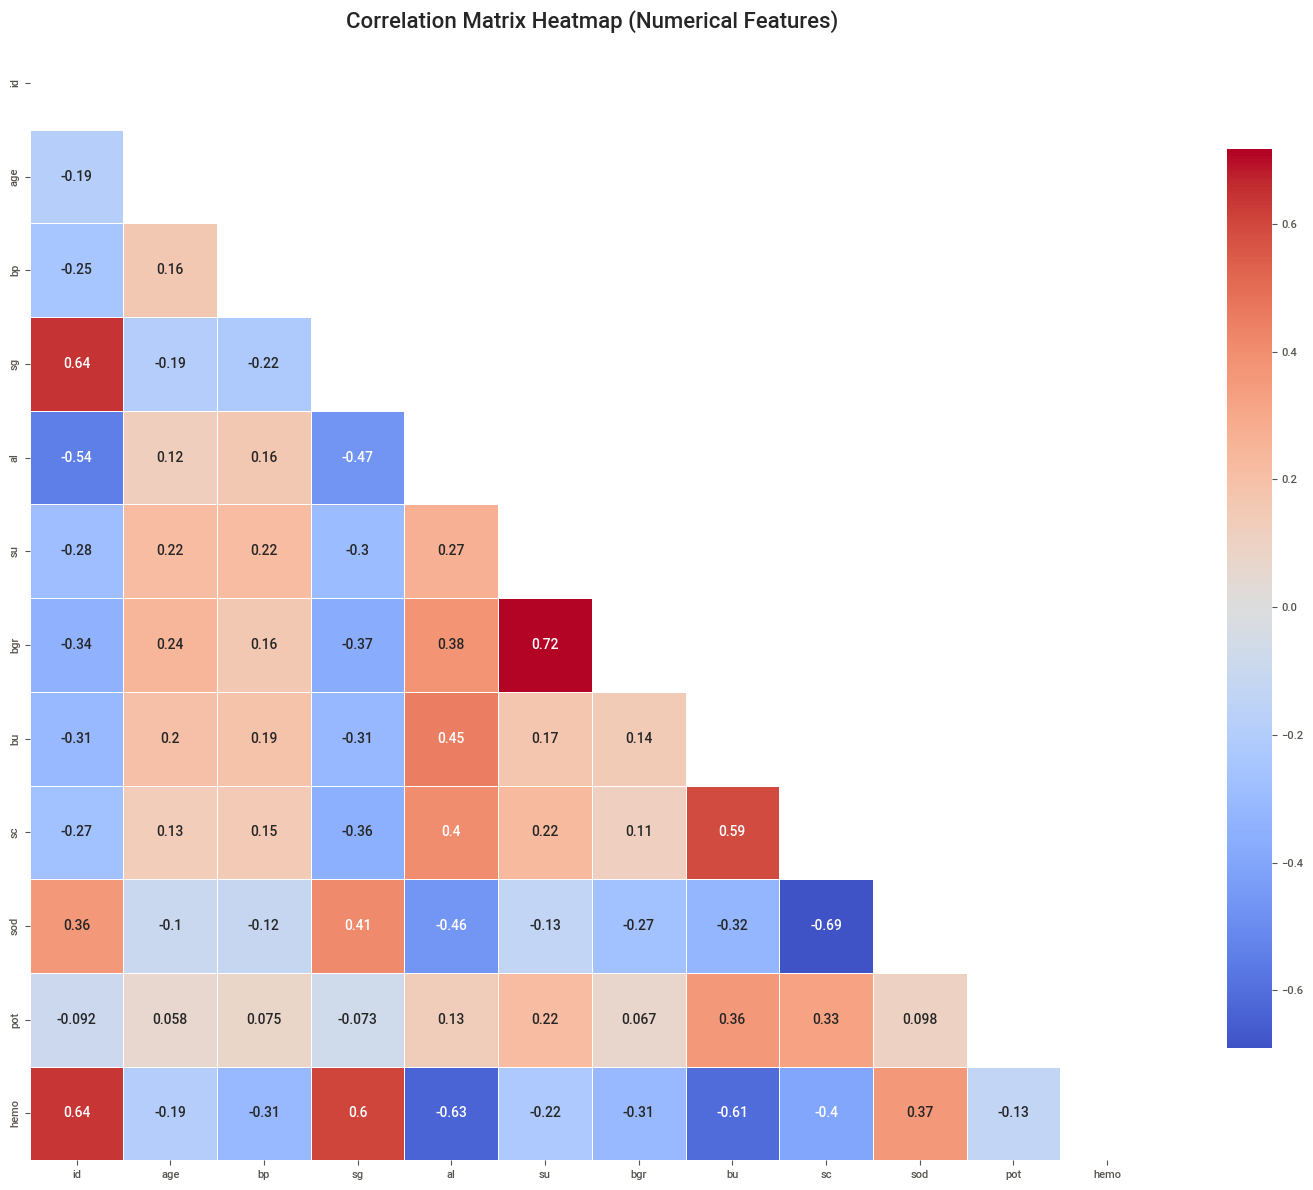


Top correlations between numerical features:
bgr   su    0.717827
sod   sc   -0.690158
sg    id    0.642156
hemo  id    0.640298
      al   -0.634632
      bu   -0.610360
      sg    0.602582
sc    bu    0.586368
al    id   -0.541993
      sg   -0.469760
dtype: float64

6. FEATURE VS TARGET ANALYSIS


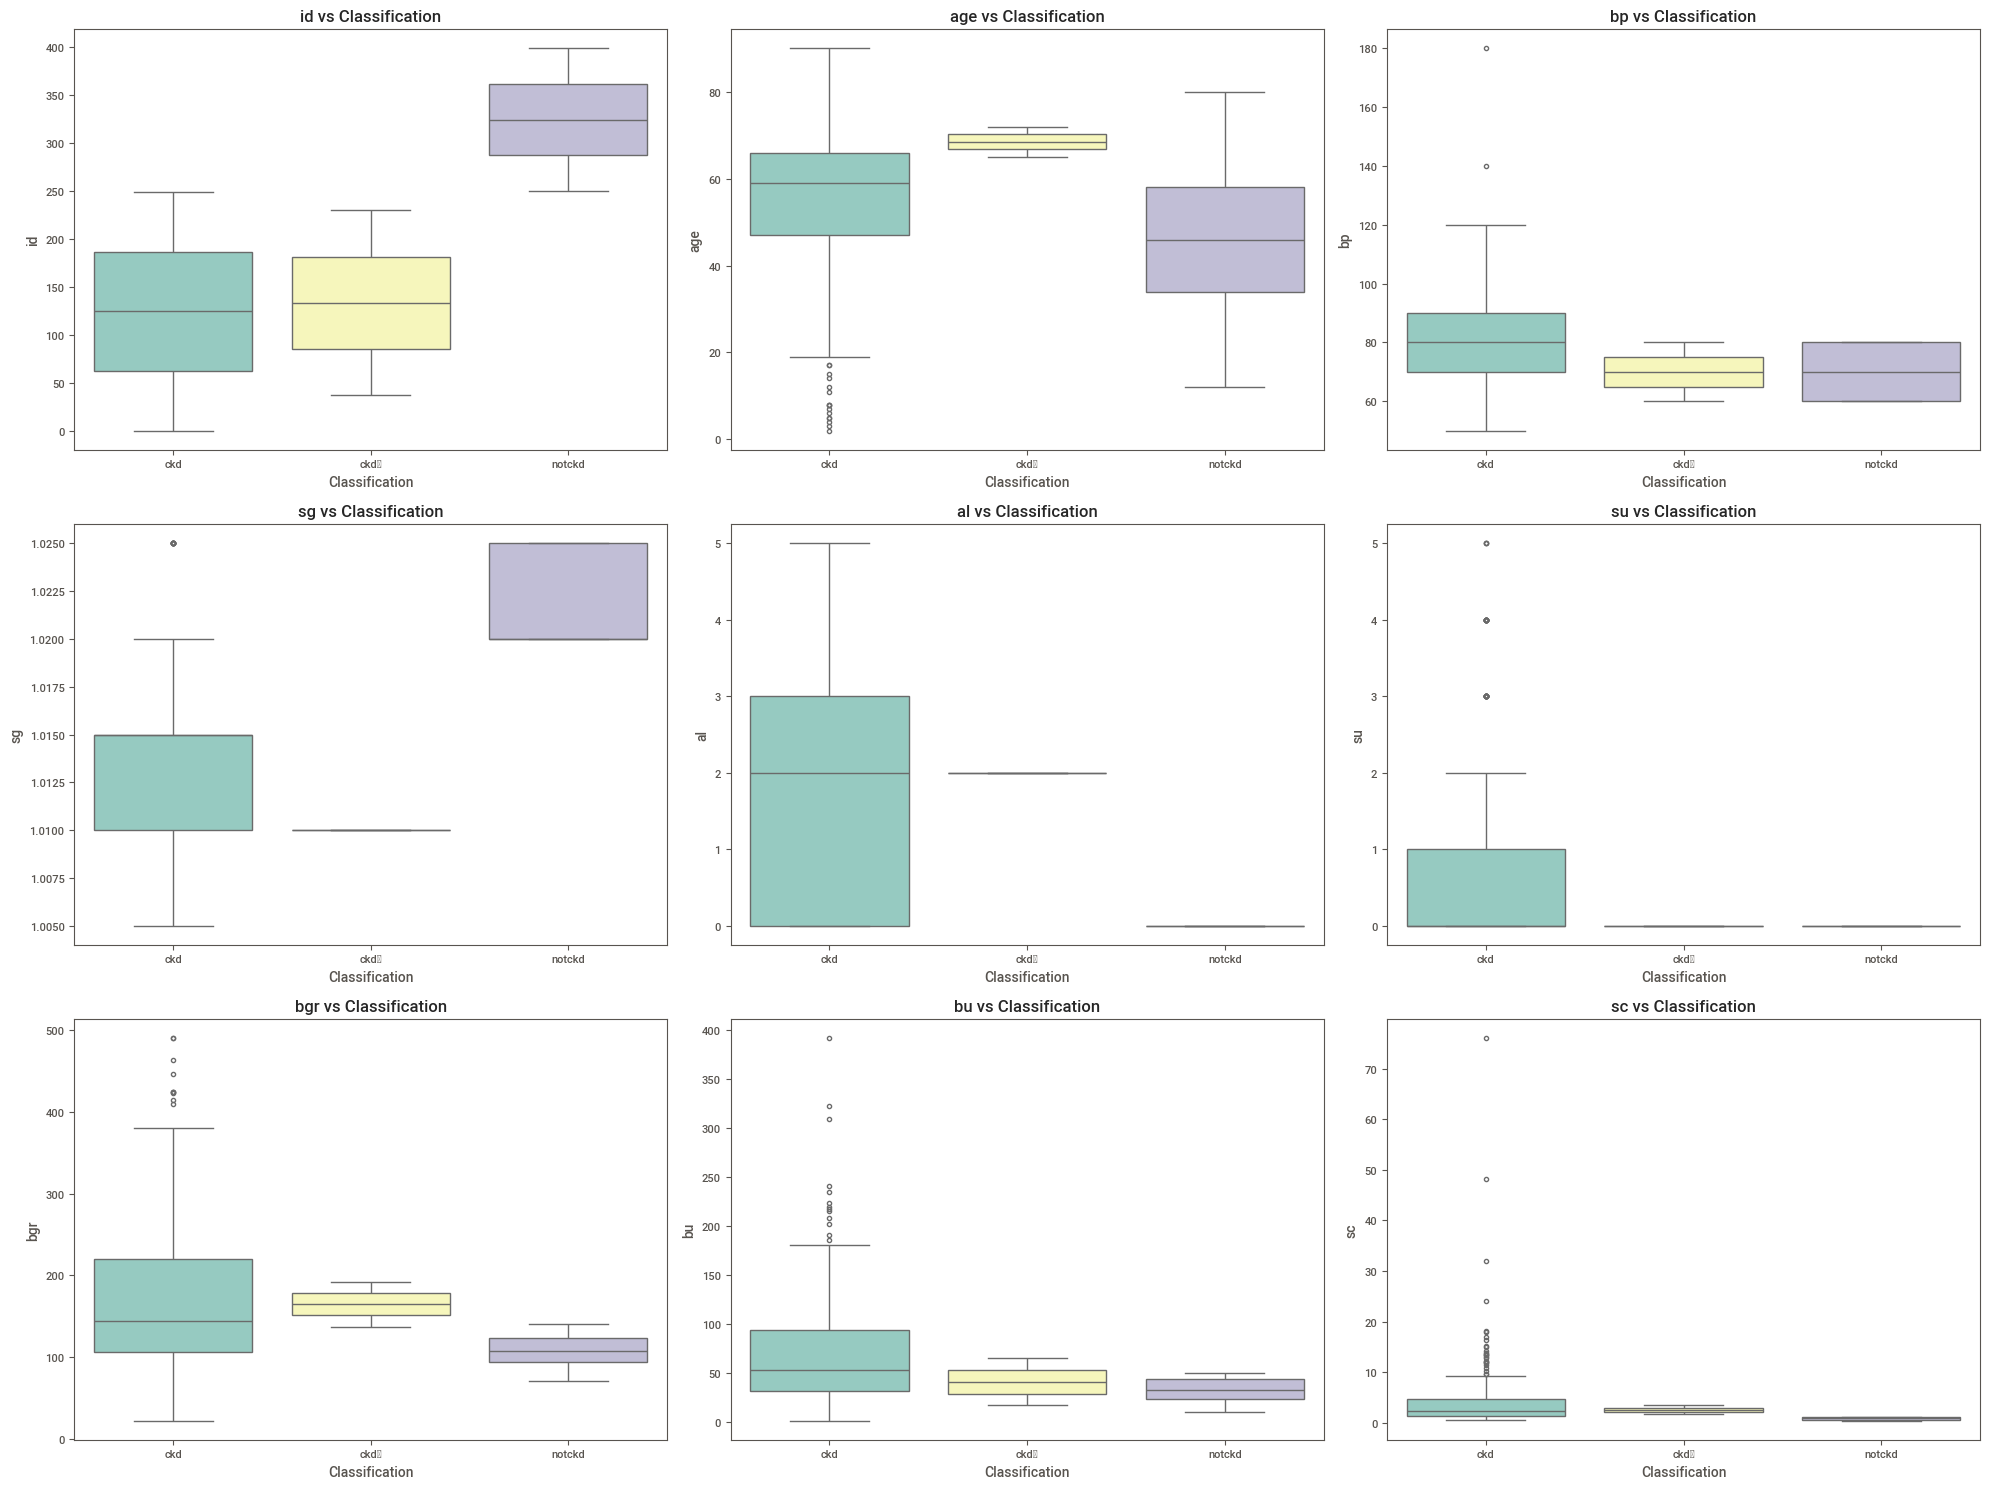


7. MISSING VALUES VISUALIZATION


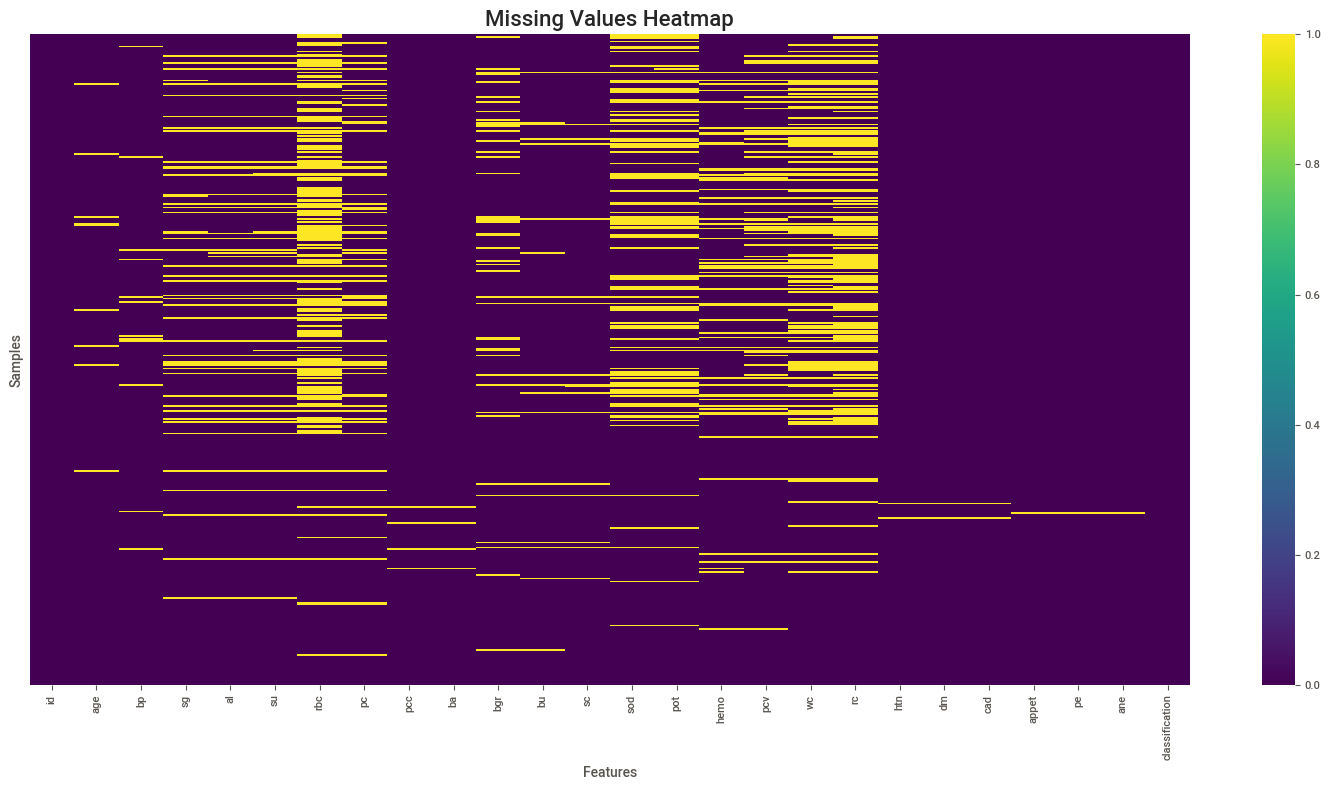

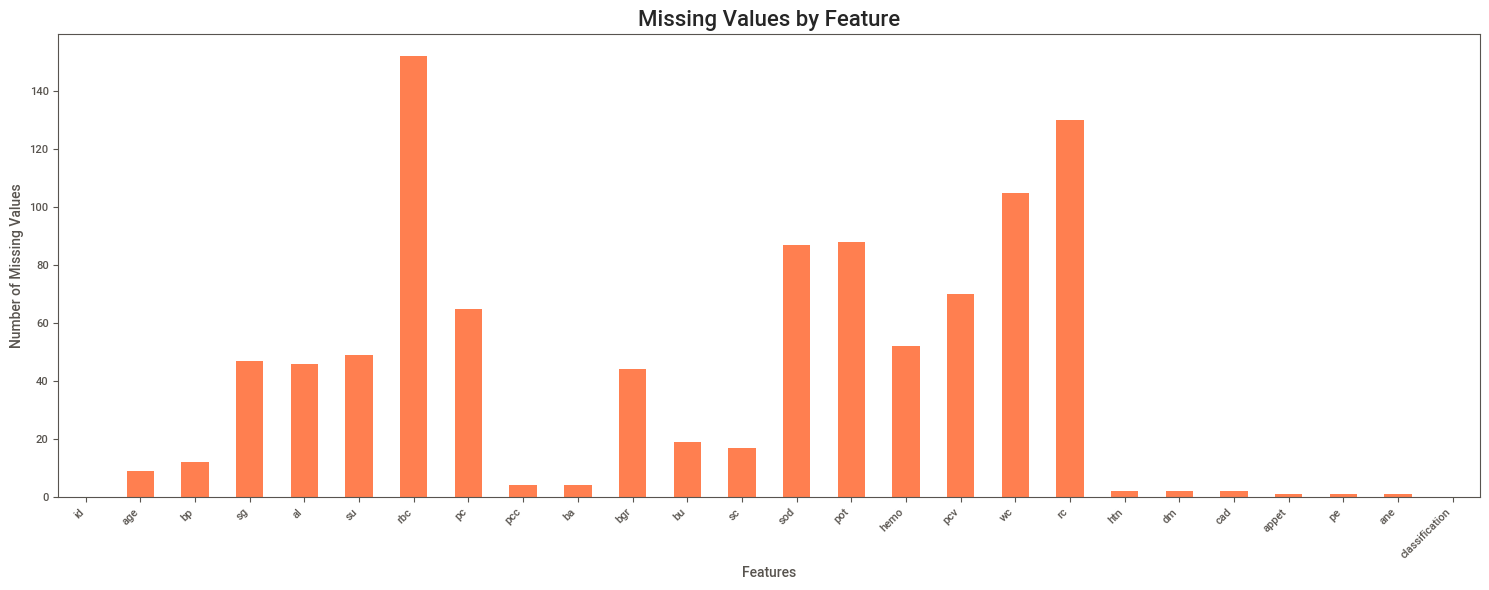


8. ADVANCED VISUALIZATIONS
Plotly visualizations skipped due to: Mime type rendering requires nbformat>=4.2.0 but it is not installed
Continuing with other analyses...

9. CATEGORICAL FEATURES ANALYSIS

rbc vs Classification:
classification         ckd     ckd\t     notckd
rbc                                            
abnormal        100.000000  0.000000   0.000000
normal           29.353234  0.497512  70.149254


<Figure size 1000x600 with 0 Axes>

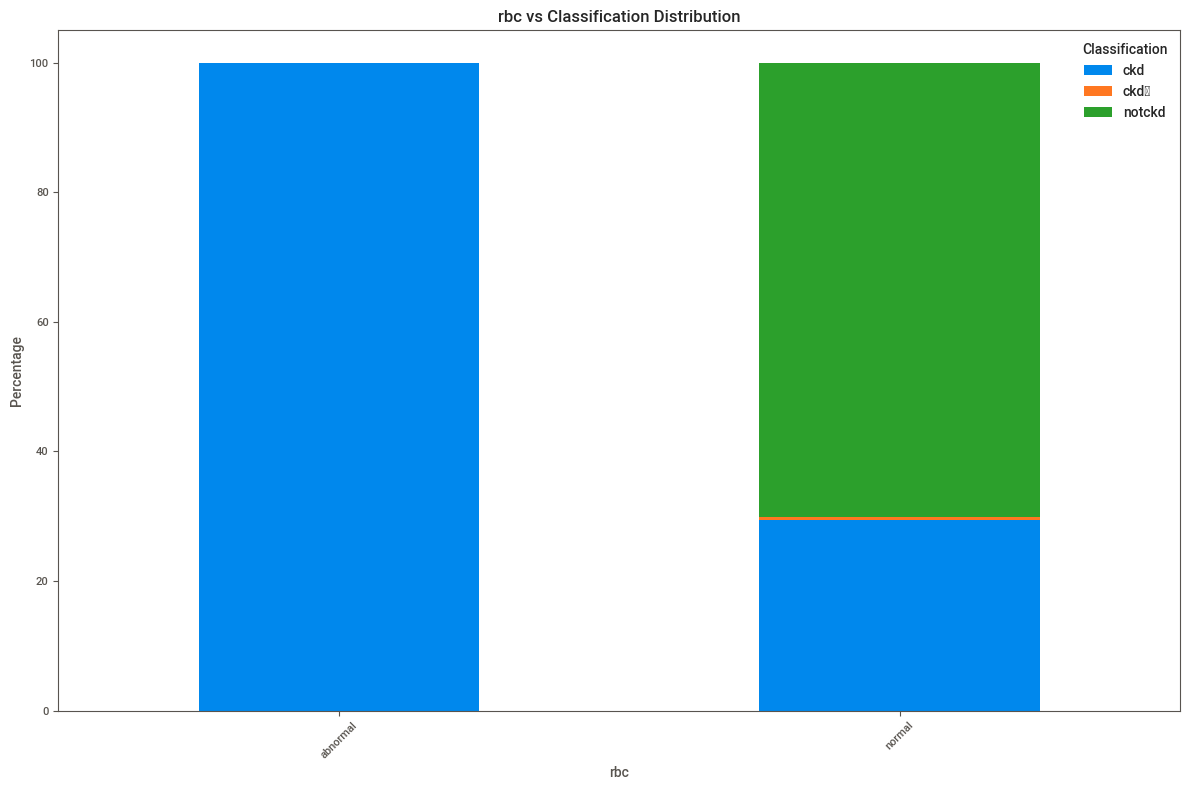


pc vs Classification:
classification        ckd     ckd\t     notckd
pc                                            
abnormal        98.684211  1.315789   0.000000
normal          45.559846  0.000000  54.440154


<Figure size 1000x600 with 0 Axes>

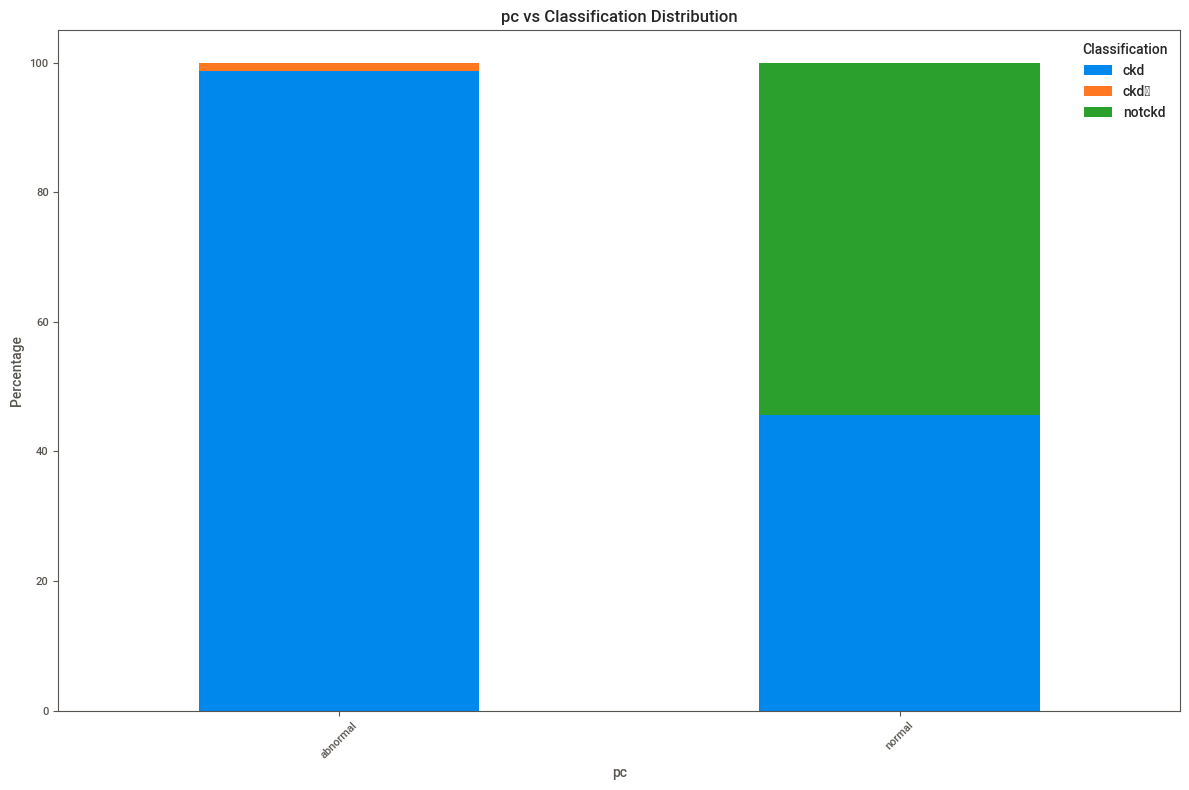


pcc vs Classification:
classification        ckd     ckd\t     notckd
pcc                                           
notpresent      58.474576  0.282486  41.242938
present         97.619048  2.380952   0.000000


<Figure size 1000x600 with 0 Axes>

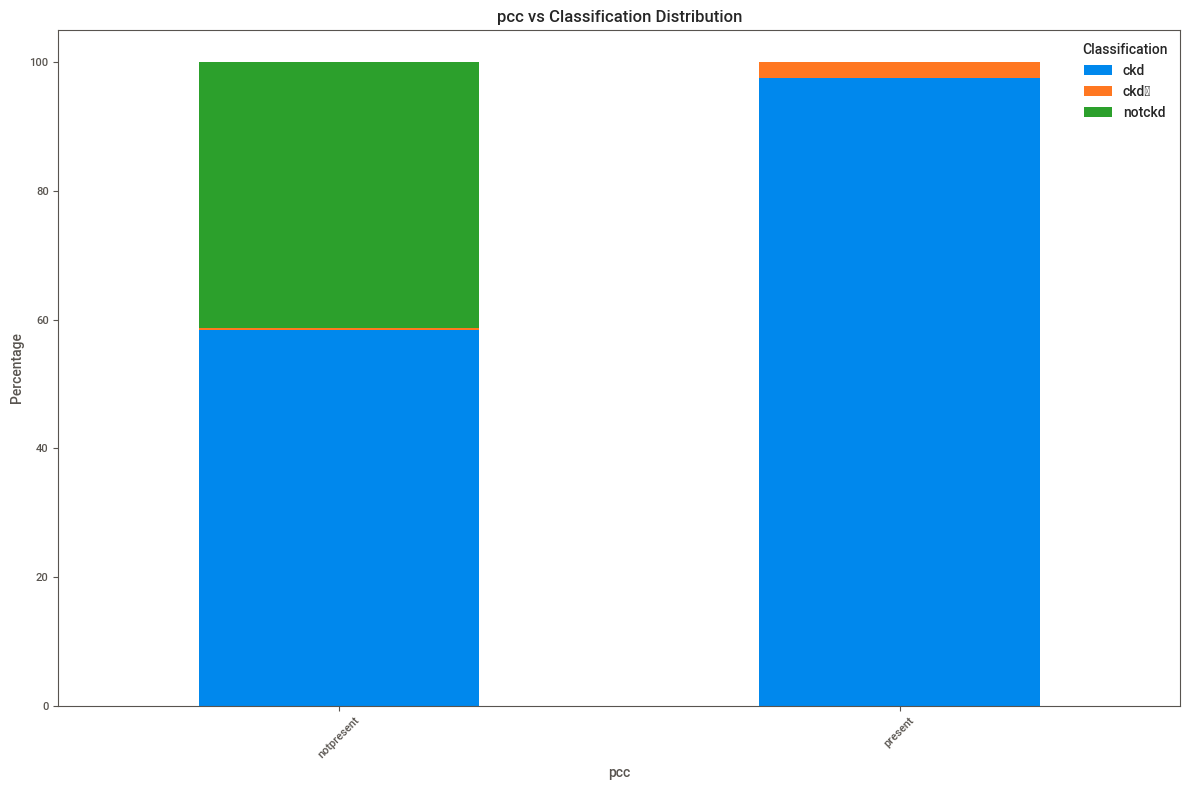


ba vs Classification:
classification         ckd     ckd\t     notckd
ba                                             
notpresent       60.427807  0.534759  39.037433
present         100.000000  0.000000   0.000000


<Figure size 1000x600 with 0 Axes>

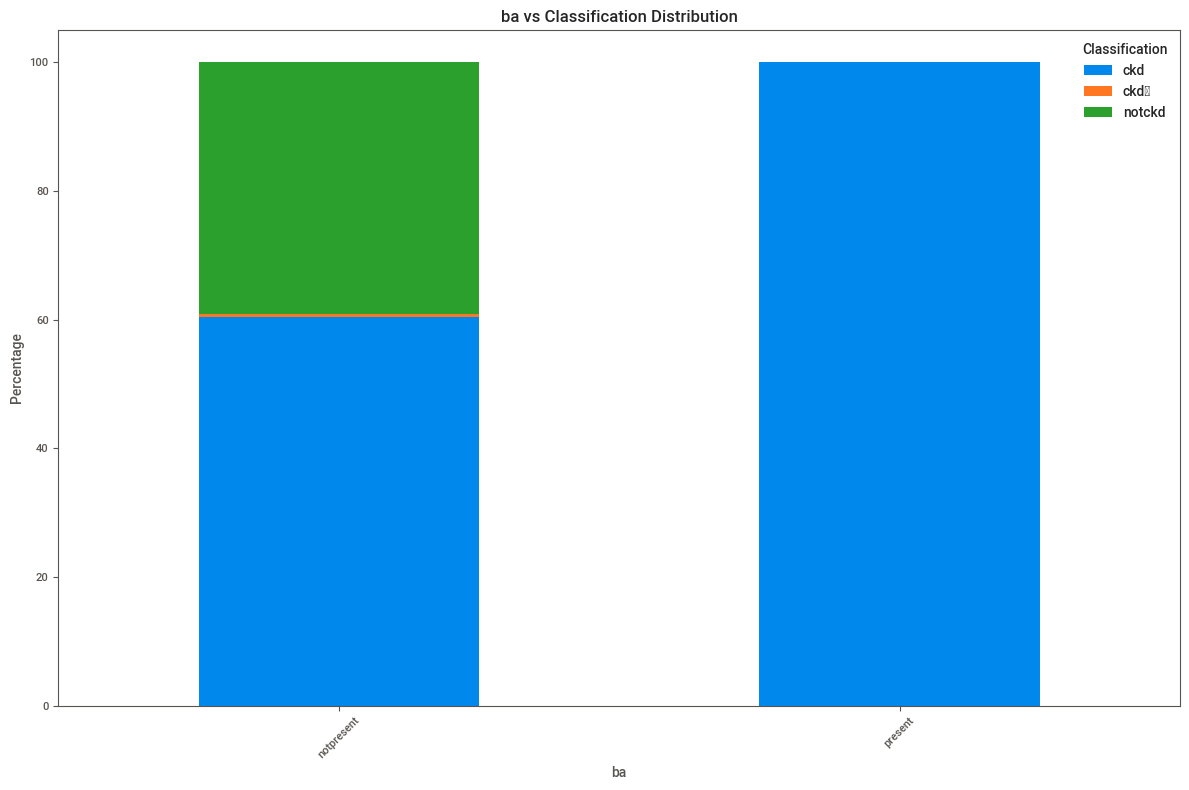


pcv vs Classification:
classification         ckd     ckd\t      notckd
pcv                                             
\t43            100.000000  0.000000    0.000000
\t?             100.000000  0.000000    0.000000
14              100.000000  0.000000    0.000000
15              100.000000  0.000000    0.000000
16              100.000000  0.000000    0.000000
17              100.000000  0.000000    0.000000
18              100.000000  0.000000    0.000000
19              100.000000  0.000000    0.000000
20              100.000000  0.000000    0.000000
21              100.000000  0.000000    0.000000
22              100.000000  0.000000    0.000000
23              100.000000  0.000000    0.000000
24              100.000000  0.000000    0.000000
25              100.000000  0.000000    0.000000
26              100.000000  0.000000    0.000000
27              100.000000  0.000000    0.000000
28               91.666667  8.333333    0.000000
29              100.000000  0.000000    0.000

<Figure size 1000x600 with 0 Axes>

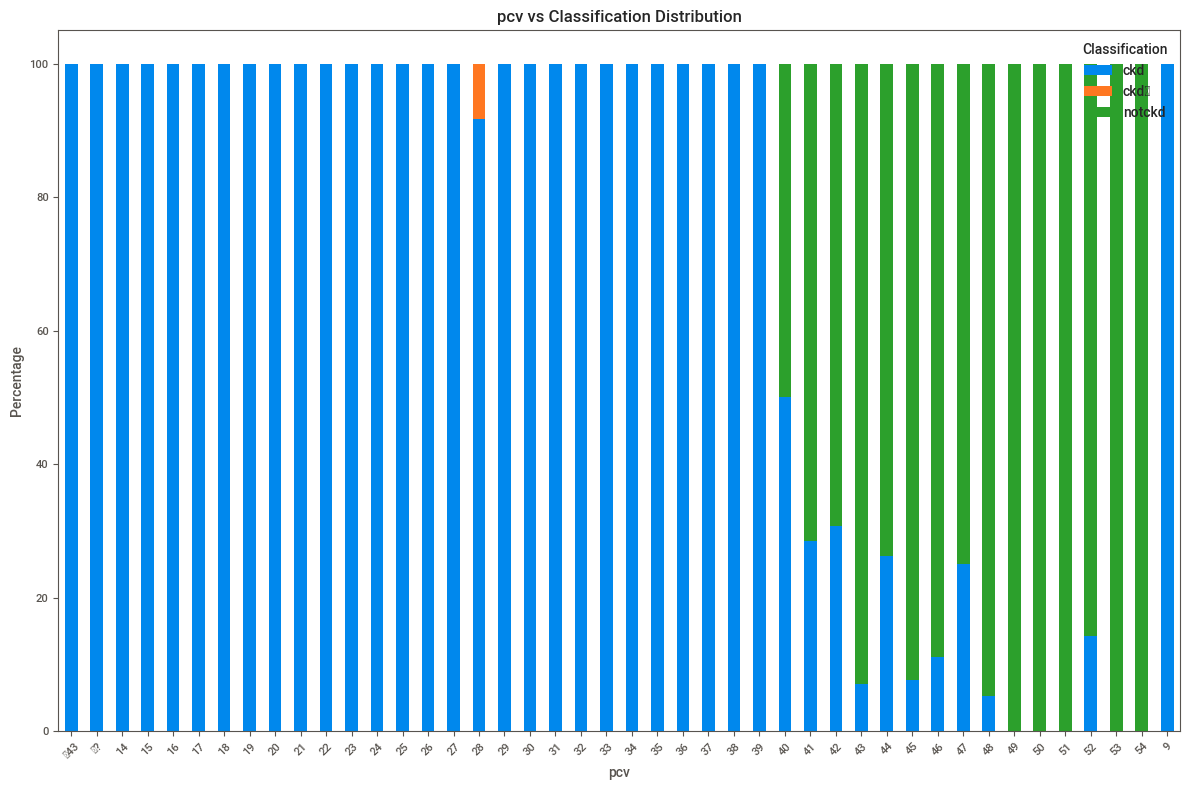


wc vs Classification:
classification         ckd  ckd\t      notckd
wc                                           
\t6200          100.000000    0.0    0.000000
\t8400          100.000000    0.0    0.000000
\t?             100.000000    0.0    0.000000
10200            80.000000    0.0   20.000000
10300            50.000000    0.0   50.000000
...                    ...    ...         ...
9500             20.000000   20.0   60.000000
9600             66.666667    0.0   33.333333
9700              0.000000    0.0  100.000000
9800             81.818182    0.0   18.181818
9900              0.000000    0.0  100.000000

[92 rows x 3 columns]


<Figure size 1000x600 with 0 Axes>

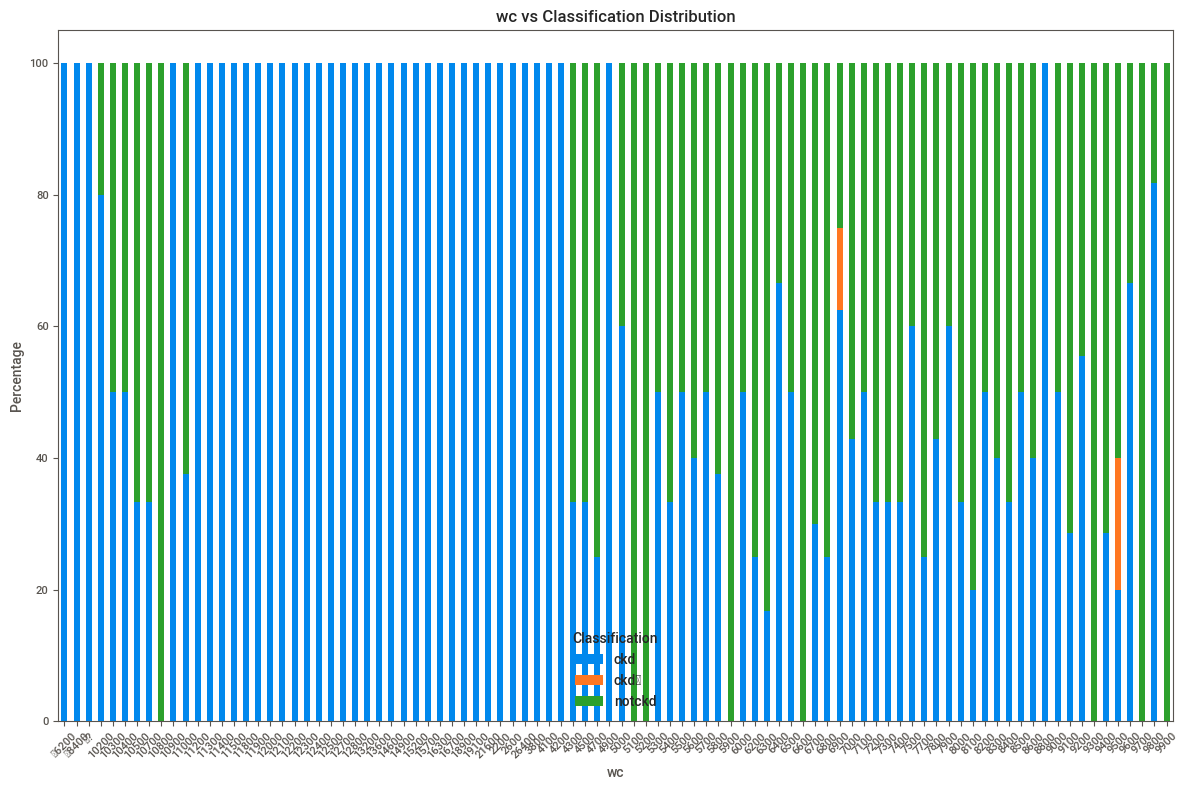


rc vs Classification:
classification         ckd  ckd\t      notckd
rc                                           
\t?             100.000000    0.0    0.000000
2.1             100.000000    0.0    0.000000
2.3             100.000000    0.0    0.000000
2.4             100.000000    0.0    0.000000
2.5              50.000000   50.0    0.000000
2.6             100.000000    0.0    0.000000
2.7             100.000000    0.0    0.000000
2.8             100.000000    0.0    0.000000
2.9             100.000000    0.0    0.000000
3               100.000000    0.0    0.000000
3.0             100.000000    0.0    0.000000
3.1             100.000000    0.0    0.000000
3.2             100.000000    0.0    0.000000
3.3             100.000000    0.0    0.000000
3.4             100.000000    0.0    0.000000
3.5             100.000000    0.0    0.000000
3.6             100.000000    0.0    0.000000
3.7             100.000000    0.0    0.000000
3.8             100.000000    0.0    0.000000
3.9        

<Figure size 1000x600 with 0 Axes>

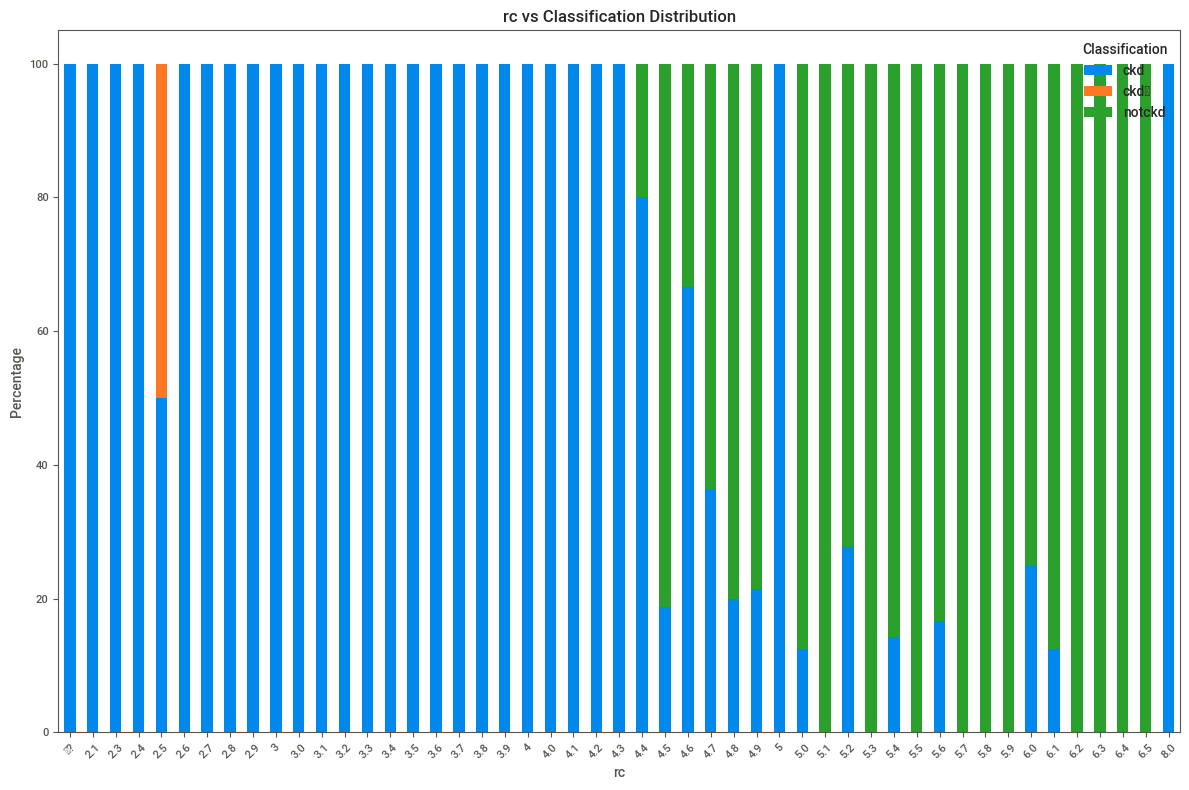


htn vs Classification:
classification        ckd     ckd\t     notckd
htn                                           
no              41.035857  0.000000  58.964143
yes             98.639456  1.360544   0.000000


<Figure size 1000x600 with 0 Axes>

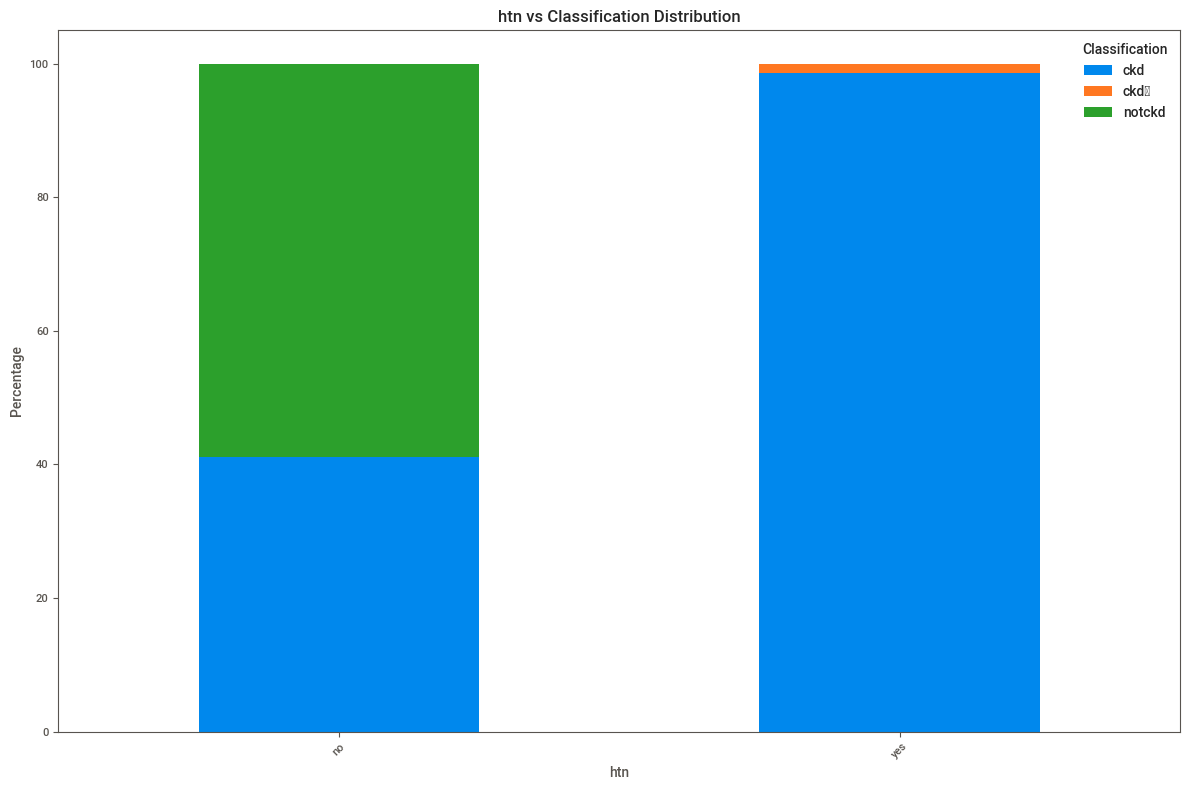


dm vs Classification:
classification         ckd     ckd\t     notckd
dm                                             
\tno            100.000000  0.000000   0.000000
\tyes           100.000000  0.000000   0.000000
 yes            100.000000  0.000000   0.000000
no               42.635659  0.000000  57.364341
yes              98.507463  1.492537   0.000000


<Figure size 1000x600 with 0 Axes>

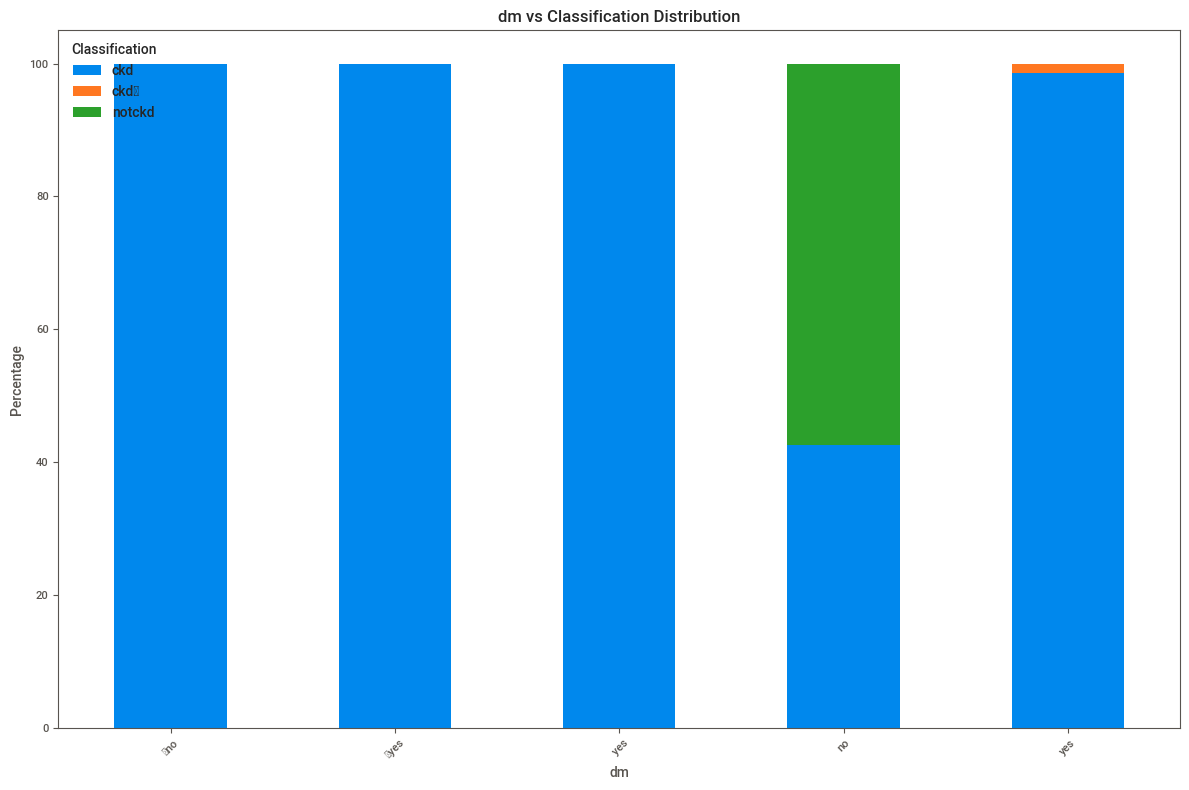


cad vs Classification:
classification         ckd     ckd\t     notckd
cad                                            
\tno            100.000000  0.000000   0.000000
no               58.563536  0.552486  40.883978
yes             100.000000  0.000000   0.000000


<Figure size 1000x600 with 0 Axes>

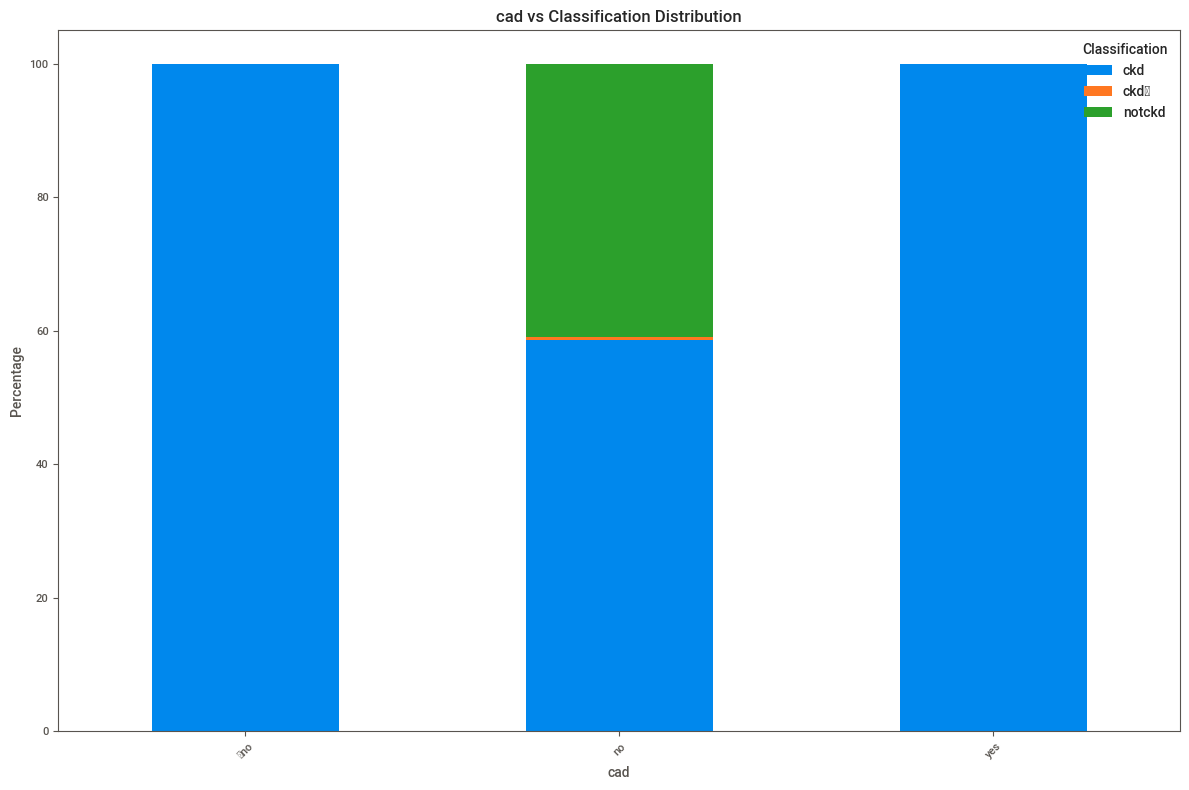


appet vs Classification:
classification        ckd     ckd\t     notckd
appet                                         
good            52.996845  0.000000  47.003155
poor            97.560976  2.439024   0.000000


<Figure size 1000x600 with 0 Axes>

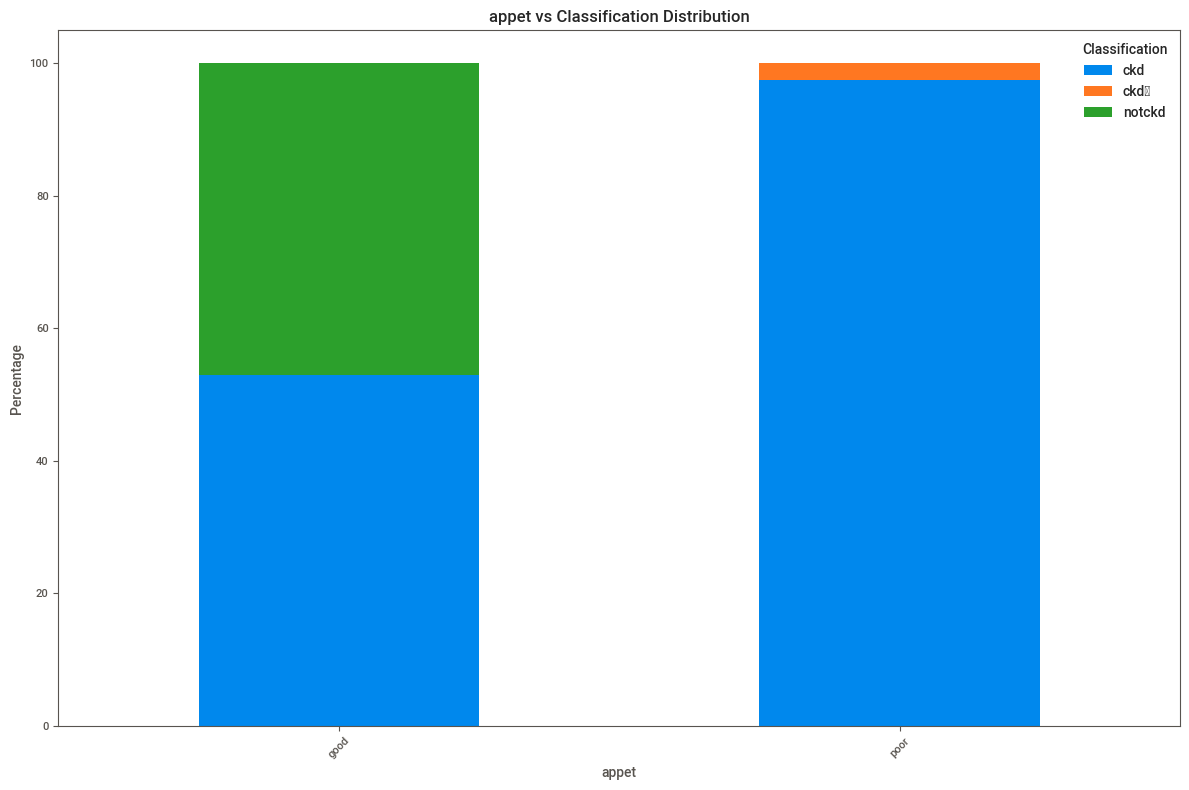


pe vs Classification:
classification         ckd     ckd\t     notckd
pe                                             
no               53.250774  0.619195  46.130031
yes             100.000000  0.000000   0.000000


<Figure size 1000x600 with 0 Axes>

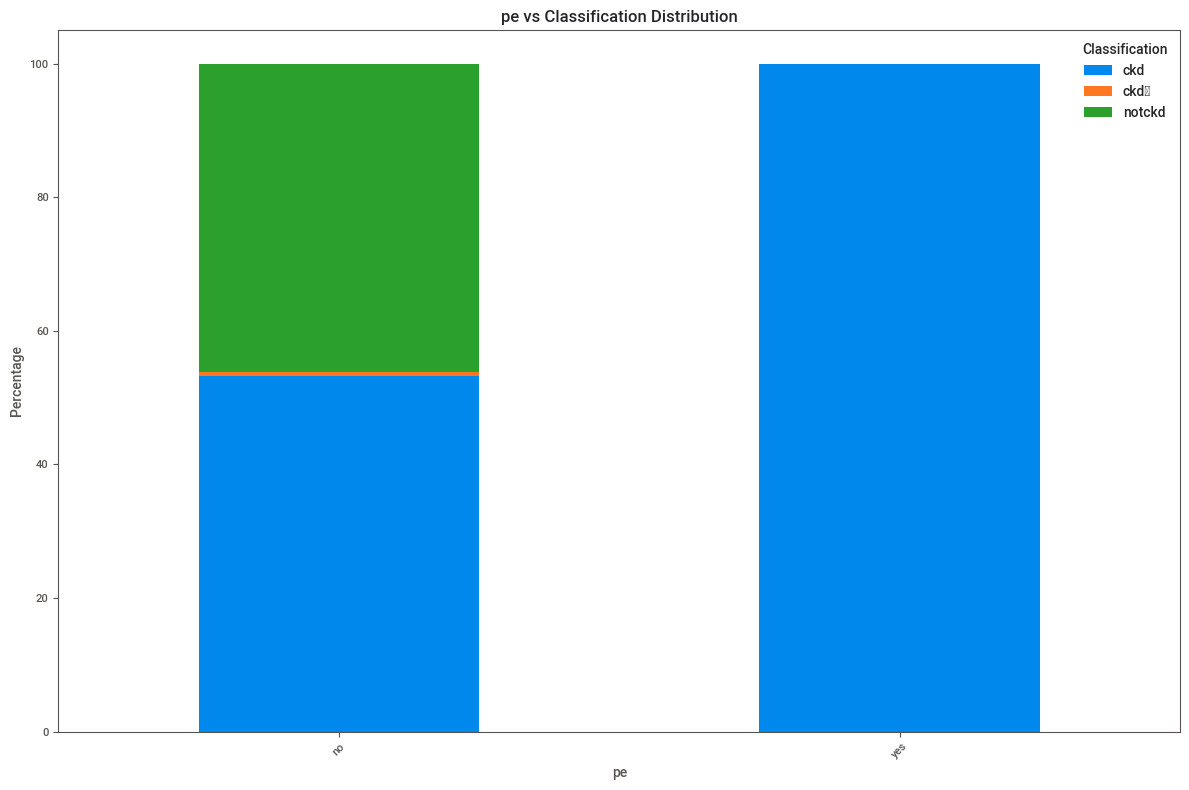


ane vs Classification:
classification        ckd     ckd\t     notckd
ane                                           
no              55.752212  0.294985  43.952802
yes             98.333333  1.666667   0.000000


<Figure size 1000x600 with 0 Axes>

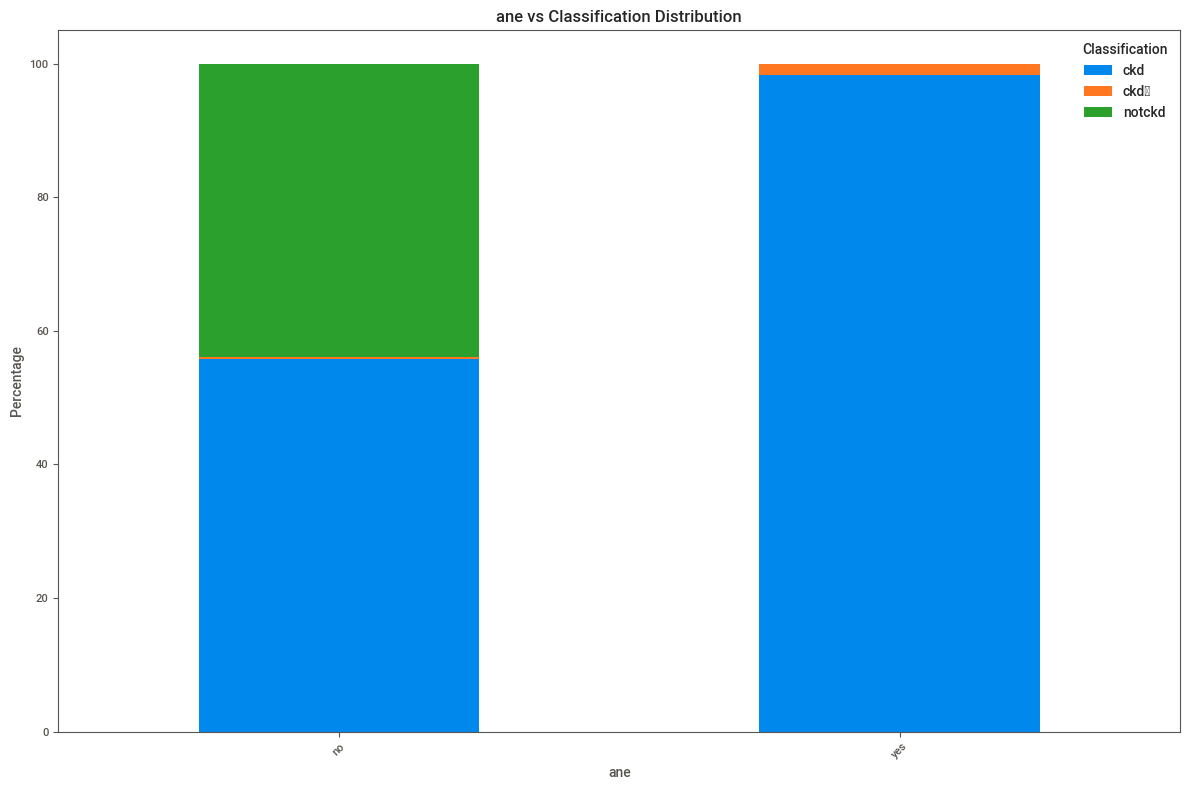


10. SUMMARY STATISTICS
Dataset shape: (400, 26)
Number of features: 26
Number of samples: 400
Missing values: 1009
Missing percentage: 9.70%
Duplicate rows: 0


In [24]:
# =============================================================================
# STEP 2: COMPREHENSIVE EXPLORATORY DATA ANALYSIS (EDA)
# =============================================================================

def comprehensive_eda(df):
    print("=== COMPREHENSIVE EDA STARTED ===")
    
    # 1. Data Quality Analysis
    print("\n1. DATA QUALITY ANALYSIS")
    print("=" * 50)
    
    # Check data types
    print("Data Types:")
    print(df.dtypes)
    
    # Check for duplicates
    duplicates = df.duplicated().sum()
    print(f"\nDuplicate rows: {duplicates}")
    
    # Check unique values in categorical columns
    categorical_cols = df.select_dtypes(include=['object']).columns
    print(f"\nCategorical columns: {list(categorical_cols)}")
    
    for col in categorical_cols:
        print(f"\n{col} unique values:")
        print(df[col].value_counts())
    
    # 2. Target Variable Analysis
    print("\n2. TARGET VARIABLE ANALYSIS")
    print("=" * 50)
    
    # Target distribution
    target_counts = df['classification'].value_counts()
    target_percentages = df['classification'].value_counts(normalize=True) * 100
    
    # Create target distribution plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Count plot
    sns.countplot(data=df, x='classification', ax=ax1, palette='viridis')
    ax1.set_title('Target Variable Distribution (Count)', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Classification')
    ax1.set_ylabel('Count')
    
    # Add value labels on bars
    for i, v in enumerate(target_counts.values):
        ax1.text(i, v + 5, str(v), ha='center', fontweight='bold')
    
    # Pie chart
    ax2.pie(target_counts.values, labels=target_counts.index, autopct='%1.1f%%', 
            colors=['#ff9999', '#66b3ff'], startangle=90)
    ax2.set_title('Target Variable Distribution (Percentage)', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # 3. Numerical Features Analysis
    print("\n3. NUMERICAL FEATURES ANALYSIS")
    print("=" * 50)
    
    numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    print(f"Numerical features: {numerical_cols}")
    
    # Statistical summary
    print("\nStatistical Summary of Numerical Features:")
    print(df[numerical_cols].describe())
    
    # 4. Distribution Analysis
    print("\n4. DISTRIBUTION ANALYSIS")
    print("=" * 50)
    
    # Create distribution plots for numerical features
    n_cols = 3
    n_rows = (len(numerical_cols) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
    axes = axes.flatten()
    
    for i, col in enumerate(numerical_cols):
        # Histogram
        axes[i].hist(df[col].dropna(), bins=30, alpha=0.7, color='skyblue', edgecolor='black')
        axes[i].set_title(f'Distribution of {col}', fontweight='bold')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frequency')
        
        # Add mean and median lines
        mean_val = df[col].mean()
        median_val = df[col].median()
        axes[i].axvline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.2f}')
        axes[i].axvline(median_val, color='green', linestyle='--', label=f'Median: {median_val:.2f}')
        axes[i].legend()
    
    # Hide empty subplots
    for i in range(len(numerical_cols), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # 5. Correlation Analysis (Numerical Features Only)
    print("\n5. CORRELATION ANALYSIS")
    print("=" * 50)
    
    # Calculate correlation matrix for numerical features only
    correlation_matrix = df[numerical_cols].corr()
    
    # Create correlation heatmap
    plt.figure(figsize=(15, 12))
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
                square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
    plt.title('Correlation Matrix Heatmap (Numerical Features)', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Show top correlations
    print("\nTop correlations between numerical features:")
    # Get upper triangle of correlation matrix
    upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
    # Find top correlations
    top_correlations = upper_triangle.unstack().dropna().sort_values(key=abs, ascending=False)
    print(top_correlations.head(10))
    
    # 6. Feature vs Target Analysis
    print("\n6. FEATURE VS TARGET ANALYSIS")
    print("=" * 50)
    
    # Create box plots for numerical features vs target
    fig, axes = plt.subplots(3, 3, figsize=(20, 15))
    axes = axes.flatten()
    
    for i, col in enumerate(numerical_cols[:9]):  # Show first 9 features
        sns.boxplot(data=df, x='classification', y=col, ax=axes[i], palette='Set3')
        axes[i].set_title(f'{col} vs Classification', fontweight='bold')
        axes[i].set_xlabel('Classification')
        axes[i].set_ylabel(col)
    
    # Hide empty subplots
    for i in range(len(numerical_cols[:9]), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # 7. Missing Values Visualization
    print("\n7. MISSING VALUES VISUALIZATION")
    print("=" * 50)
    
    # Create missing values heatmap
    plt.figure(figsize=(15, 8))
    sns.heatmap(df.isnull(), yticklabels=False, cbar=True, cmap='viridis')
    plt.title('Missing Values Heatmap', fontsize=16, fontweight='bold')
    plt.xlabel('Features')
    plt.ylabel('Samples')
    plt.tight_layout()
    plt.show()
    
    # Missing values bar plot
    missing_data = df.isnull().sum()
    plt.figure(figsize=(15, 6))
    missing_data.plot(kind='bar', color='coral')
    plt.title('Missing Values by Feature', fontsize=16, fontweight='bold')
    plt.xlabel('Features')
    plt.ylabel('Number of Missing Values')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # 8. Advanced Visualizations with Plotly (Optional - can be skipped if issues)
    print("\n8. ADVANCED VISUALIZATIONS")
    print("=" * 50)
    
    try:
        # Create interactive correlation plot
        fig = go.Figure(data=go.Heatmap(
            z=correlation_matrix.values,
            x=correlation_matrix.columns,
            y=correlation_matrix.columns,
            colorscale='RdBu',
            zmid=0,
            text=np.round(correlation_matrix.values, 2),
            texttemplate="%{text}",
            textfont={"size": 10},
            hoverongaps=False
        ))
        
        fig.update_layout(
            title='Interactive Correlation Matrix (Numerical Features)',
            width=800,
            height=800,
            xaxis_title="Features",
            yaxis_title="Features"
        )
        fig.show()
        
        # Create 3D scatter plot for top 3 correlated features
        if len(numerical_cols) >= 3:
            # Get top 3 correlated features
            top_corr_pairs = top_correlations.head(3)
            feature1, feature2 = top_corr_pairs.index[0]
            
            # Find a third feature that's not in the top pair
            third_feature = None
            for col in numerical_cols:
                if col not in [feature1, feature2]:
                    third_feature = col
                    break
            
            if third_feature:
                fig = go.Figure(data=[go.Scatter3d(
                    x=df[feature1],
                    y=df[feature2],
                    z=df[third_feature],
                    mode='markers',
                    marker=dict(
                        size=8,
                        color=df['classification'].map({'ckd': 1, 'notckd': 0}),
                        colorscale='Viridis',
                        opacity=0.8
                    ),
                    text=df['classification'],
                    hovertemplate='<b>%{text}</b><br>' +
                                  f'{feature1}: %{{x}}<br>' +
                                  f'{feature2}: %{{y}}<br>' +
                                  f'{third_feature}: %{{z}}<extra></extra>'
                )])
                
                fig.update_layout(
                    title=f'3D Scatter Plot: {feature1} vs {feature2} vs {third_feature}',
                    scene=dict(
                        xaxis_title=feature1,
                        yaxis_title=feature2,
                        zaxis_title=third_feature
                    ),
                    width=800,
                    height=600
                )
                fig.show()
    except Exception as e:
        print(f"Plotly visualizations skipped due to: {e}")
        print("Continuing with other analyses...")
    
    # 9. Categorical Features Analysis
    print("\n9. CATEGORICAL FEATURES ANALYSIS")
    print("=" * 50)
    
    # Analyze categorical features vs target
    for col in categorical_cols:
        if col != 'classification':
            print(f"\n{col} vs Classification:")
            crosstab = pd.crosstab(df[col], df['classification'], normalize='index') * 100
            print(crosstab)
            
            # Create visualization
            plt.figure(figsize=(10, 6))
            crosstab.plot(kind='bar', stacked=True)
            plt.title(f'{col} vs Classification Distribution')
            plt.xlabel(col)
            plt.ylabel('Percentage')
            plt.legend(title='Classification')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()
    
    # 10. Summary Statistics
    print("\n10. SUMMARY STATISTICS")
    print("=" * 50)
    
    print(f"Dataset shape: {df.shape}")
    print(f"Number of features: {df.shape[1]}")
    print(f"Number of samples: {df.shape[0]}")
    print(f"Missing values: {df.isnull().sum().sum()}")
    print(f"Missing percentage: {(df.isnull().sum().sum() / (df.shape[0] * df.shape[1]) * 100):.2f}%")
    print(f"Duplicate rows: {df.duplicated().sum()}")
    
    return df

# Run comprehensive EDA
df_eda = comprehensive_eda(df)

In [25]:
# =============================================================================
# STEP 2.1: YDATA PROFILING - AUTOMATED COMPREHENSIVE EDA
# =============================================================================

from ydata_profiling import ProfileReport

print("=== YDATA PROFILING - AUTOMATED COMPREHENSIVE EDA ===")
print("Generating comprehensive profile report...")

# Create a comprehensive profile report
profile = ProfileReport(df, 
                       title="Kidney Disease Dataset - Comprehensive Analysis",
                       explorative=True)

# Save the report as HTML file (this will work reliably)
profile.to_file("kidney_disease_profile_report.html")
print("Profile report saved as 'kidney_disease_profile_report.html'")

# Display basic statistics in the notebook
print("\n=== BASIC DATASET STATISTICS ===")
print(f"Dataset shape: {df.shape}")
print(f"Number of features: {df.shape[1]}")
print(f"Number of samples: {df.shape[0]}")
print(f"Columns: {list(df.columns)}")
print(f"Data types:\n{df.dtypes}")

print("\n=== MISSING VALUES ANALYSIS ===")
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df) * 100).round(2)
missing_df = pd.DataFrame({
    'Missing Count': missing_values,
    'Missing Percentage': missing_percentage
})
print(missing_df[missing_df['Missing Count'] > 0])

print("\n=== DUPLICATE ROWS ANALYSIS ===")
duplicates = df.duplicated().sum()
duplicate_percentage = (duplicates / len(df) * 100).round(2)
print(f"Duplicate rows: {duplicates}")
print(f"Duplicate rows percentage: {duplicate_percentage}%")

print("\n=== DATA QUALITY SUMMARY ===")
print(f"Total missing cells: {df.isnull().sum().sum()}")
print(f"Total missing cells percentage: {(df.isnull().sum().sum() / (df.shape[0] * df.shape[1]) * 100):.2f}%")
print(f"Columns with missing values: {missing_values[missing_values > 0].count()}")

print("\n=== NEXT STEPS ===")
print("1. Open 'kidney_disease_profile_report.html' in your browser for detailed analysis")
print("2. Review the missing values and data quality issues above")
print("3. Proceed to the next step in your methodology (Preprocessing)")

=== YDATA PROFILING - AUTOMATED COMPREHENSIVE EDA ===
Generating comprehensive profile report...


Export report to file: 100%|██████████| 1/1 [00:00<00:00, 26.16it/s]

Profile report saved as 'kidney_disease_profile_report.html'

=== BASIC DATASET STATISTICS ===
Dataset shape: (400, 26)
Number of features: 26
Number of samples: 400
Columns: ['id', 'age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane', 'classification']
Data types:
id                  int64
age               float64
bp                float64
sg                float64
al                float64
su                float64
rbc                object
pc                 object
pcc                object
ba                 object
bgr               float64
bu                float64
sc                float64
sod               float64
pot               float64
hemo              float64
pcv                object
wc                 object
rc                 object
htn                object
dm                 object
cad                object
appet              object
pe                 object
ane  


1. DATA TYPE ANALYSIS AND CONVERSION
Original data types:
id                  int64
age               float64
bp                float64
sg                float64
al                float64
su                float64
rbc                object
pc                 object
pcc                object
ba                 object
bgr               float64
bu                float64
sc                float64
sod               float64
pot               float64
hemo              float64
pcv                object
wc                 object
rc                 object
htn                object
dm                 object
cad                object
appet              object
pe                 object
ane                object
classification     object
dtype: object

Columns that might be numeric but are stored as object: []

2. MISSING VALUES ANALYSIS AND TREATMENT
Missing values summary:
       Missing Count  Missing Percentage
age                9                2.25
bp                12                3.00
sg

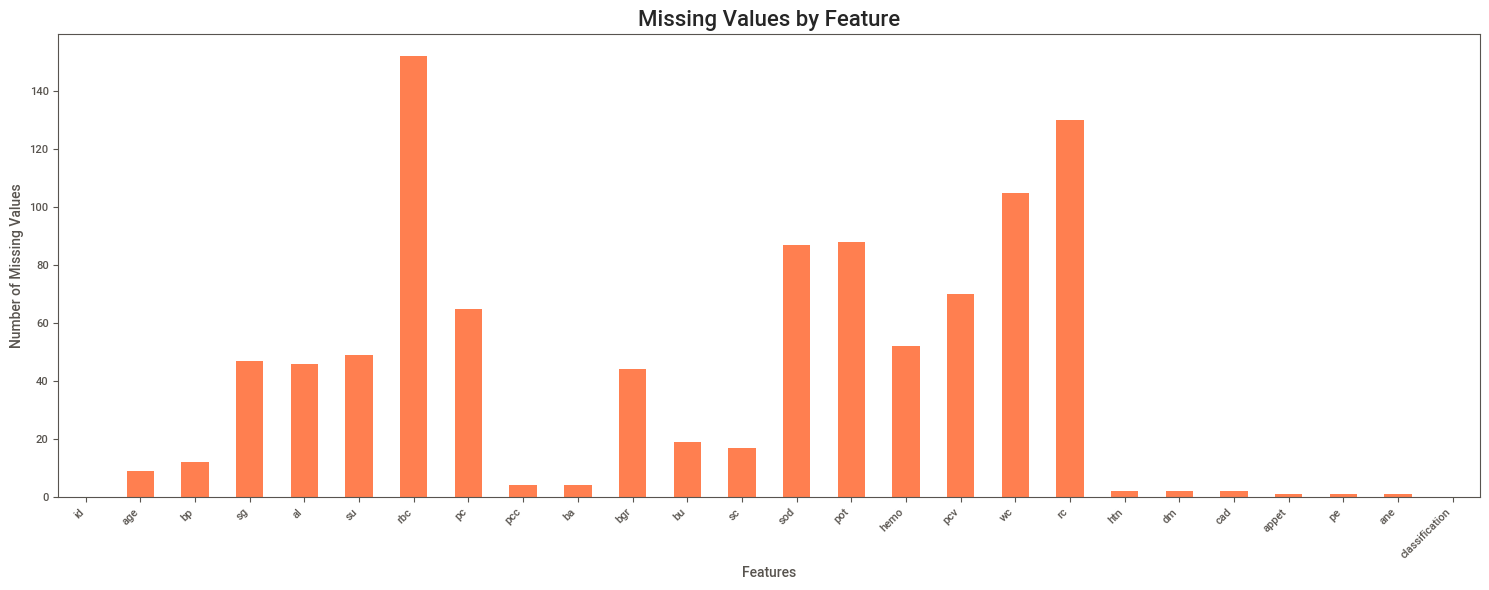

In [53]:
df_processed = df.copy()
    
# 1. Data Type Analysis and Conversion
print("\n1. DATA TYPE ANALYSIS AND CONVERSION")
print("=" * 50)

print("Original data types:")
print(df_processed.dtypes)

# Check for mixed data types in columns
mixed_columns = []
for col in df_processed.columns:
    if df_processed[col].dtype == 'object':
        # Check if it's actually numeric
        try:
            pd.to_numeric(df_processed[col], errors='raise')
            mixed_columns.append(col)
        except:
            pass

print(f"\nColumns that might be numeric but are stored as object: {mixed_columns}")

# Convert mixed columns to numeric
for col in mixed_columns:
    df_processed[col] = pd.to_numeric(df_processed[col], errors='coerce')
    print(f"Converted {col} to numeric")

# print("Lasrly")
# print(df_processed.dtypes)


# 2. Missing Values Analysis and Treatment
print("\n2. MISSING VALUES ANALYSIS AND TREATMENT")
print("=" * 50)

# Analyze missing values
missing_data = df_processed.isnull().sum()
missing_percentage = (missing_data / len(df_processed) * 100).round(2)

missing_summary = pd.DataFrame({
    'Missing Count': missing_data,
    'Missing Percentage': missing_percentage
})

print("Missing values summary:")
print(missing_summary[missing_summary['Missing Count'] > 0])

# Visualize missing values pattern
plt.figure(figsize=(15, 6))
missing_data.plot(kind='bar', color='coral')
plt.title('Missing Values by Feature', fontsize=16, fontweight='bold')
plt.xlabel('Features')
plt.ylabel('Number of Missing Values')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
# plt.show()


# 7. Data Quality Check After Preprocessing
print("\n7. DATA QUALITY CHECK AFTER PREPROCESSING")
print("=" * 50)

print(f"Final dataset shape: {df_processed.shape}")
print(f"Missing values after preprocessing: {df_processed.isnull().sum().sum()}")
print(f"Duplicate rows: {df_processed.duplicated().sum()}")

# Check data types after preprocessing
print("\nFinal data types:")
print(df_processed.dtypes)
    

df_processed.info()

In [ ]:
# =============================================================================
# STEP 3: COMPREHENSIVE DATA PREPROCESSING (FIXED VERSION)
# =============================================================================

def comprehensive_preprocessing(df):
    print("=== COMPREHENSIVE DATA PREPROCESSING STARTED ===")
    
    # Create a copy to avoid modifying original data
    df_processed = df.copy()
    
    # 1. Data Type Analysis and Conversion
    print("\n1. DATA TYPE ANALYSIS AND CONVERSION")
    print("=" * 50)
    
    print("Original data types:")
    print(df_processed.dtypes)
    
    # Check for mixed data types in columns
    mixed_columns = []
    for col in df_processed.columns:
        if df_processed[col].dtype == 'object':
            # Check if it's actually numeric
            try:
                pd.to_numeric(df_processed[col], errors='raise')
                mixed_columns.append(col)
            except:
                pass
    
    print(f"\nColumns that might be numeric but are stored as object: {mixed_columns}")
    
    # Convert mixed columns to numeric
    for col in mixed_columns:
        df_processed[col] = pd.to_numeric(df_processed[col], errors='coerce')
        print(f"Converted {col} to numeric")
    
    # 2. Missing Values Analysis and Treatment
    print("\n2. MISSING VALUES ANALYSIS AND TREATMENT")
    print("=" * 50)
    
    # Analyze missing values
    missing_data = df_processed.isnull().sum()
    missing_percentage = (missing_data / len(df_processed) * 100).round(2)
    
    missing_summary = pd.DataFrame({
        'Missing Count': missing_data,
        'Missing Percentage': missing_percentage
    })
    
    print("Missing values summary:")
    print(missing_summary[missing_summary['Missing Count'] > 0])
    
    # Visualize missing values pattern
    plt.figure(figsize=(15, 6))
    missing_data.plot(kind='bar', color='coral')
    plt.title('Missing Values by Feature', fontsize=16, fontweight='bold')
    plt.xlabel('Features')
    plt.ylabel('Number of Missing Values')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # 3. Missing Values Imputation Strategy
    print("\n3. MISSING VALUES IMPUTATION STRATEGY")
    print("=" * 50)
    
    # Separate numerical and categorical columns
    numerical_cols = df_processed.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = df_processed.select_dtypes(include=['object']).columns.tolist()
    
    print(f"Numerical columns: {numerical_cols}")
    print(f"Categorical columns: {categorical_cols}")
    
    # Impute missing values
    print("\nImputing missing values...")
    
    # For numerical columns - use median (more robust than mean)
    for col in numerical_cols:
        if df_processed[col].isnull().sum() > 0:
            median_val = df_processed[col].median()
            df_processed[col].fillna(median_val, inplace=True)
            print(f"Imputed {col} with median: {median_val:.2f}")
    
    # For categorical columns - use mode
    for col in categorical_cols:
        if df_processed[col].isnull().sum() > 0:
            mode_val = df_processed[col].mode()[0]
            df_processed[col].fillna(mode_val, inplace=True)
            print(f"Imputed {col} with mode: {mode_val}")
    
    # 4. Outlier Detection and Treatment
    print("\n4. OUTLIER DETECTION AND TREATMENT")
    print("=" * 50)
    
    # Detect outliers using IQR method
    outlier_summary = {}
    
    for col in numerical_cols:
        Q1 = df_processed[col].quantile(0.25)
        Q3 = df_processed[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = df_processed[(df_processed[col] < lower_bound) | (df_processed[col] > upper_bound)]
        outlier_count = len(outliers)
        outlier_percentage = (outlier_count / len(df_processed)) * 100
        
        outlier_summary[col] = {
            'outlier_count': outlier_count,
            'outlier_percentage': outlier_percentage,
            'lower_bound': lower_bound,
            'upper_bound': upper_bound
        }
        
        print(f"{col}: {outlier_count} outliers ({outlier_percentage:.2f}%)")
    
    # Visualize outliers
    fig, axes = plt.subplots(3, 3, figsize=(20, 15))
    axes = axes.flatten()
    
    for i, col in enumerate(numerical_cols[:9]):
        # Box plot
        axes[i].boxplot(df_processed[col].dropna())
        axes[i].set_title(f'Outliers in {col}', fontweight='bold')
        axes[i].set_ylabel(col)
    
    # Hide empty subplots
    for i in range(len(numerical_cols[:9]), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # 5. Feature Engineering
    print("\n5. FEATURE ENGINEERING")
    print("=" * 50)
    
    # Create age groups
    if 'age' in df_processed.columns:
        df_processed['age_group'] = pd.cut(df_processed['age'], 
                                         bins=[0, 30, 50, 70, 100], 
                                         labels=['Young', 'Middle', 'Senior', 'Elderly'])
        print("Created age_group feature")
    
    # Create BMI categories if both height and weight are available
    if 'height' in df_processed.columns and 'weight' in df_processed.columns:
        # Calculate BMI (assuming height is in cm and weight is in kg)
        # Handle division by zero and invalid values
        height_clean = df_processed['height'].replace(0, np.nan)
        df_processed['bmi'] = df_processed['weight'] / ((height_clean / 100) ** 2)
        
        # Handle infinite values
        df_processed['bmi'] = df_processed['bmi'].replace([np.inf, -np.inf], np.nan)
        
        # Create BMI categories only for valid BMI values
        valid_bmi_mask = df_processed['bmi'].notna()
        if valid_bmi_mask.any():
            df_processed.loc[valid_bmi_mask, 'bmi_category'] = pd.cut(
                df_processed.loc[valid_bmi_mask, 'bmi'], 
                bins=[0, 18.5, 25, 30, 100], 
                labels=['Underweight', 'Normal', 'Overweight', 'Obese']
            )
        print("Created BMI and BMI category features")
    
    # 6. Categorical Encoding
    print("\n6. CATEGORICAL ENCODING")
    print("=" * 50)
    
    # Get updated categorical columns after preprocessing
    categorical_cols = df_processed.select_dtypes(include=['object']).columns.tolist()
    if 'classification' in categorical_cols:
        categorical_cols.remove('classification')  # Keep target as is
    
    print(f"Categorical columns to encode: {categorical_cols}")
    
    # Label encoding for categorical variables
    from sklearn.preprocessing import LabelEncoder
    
    label_encoders = {}
    for col in categorical_cols:
        le = LabelEncoder()
        df_processed[f'{col}_encoded'] = le.fit_transform(df_processed[col])
        label_encoders[col] = le
        print(f"Label encoded {col}")
    
    # 7. FINAL MISSING VALUES CLEANUP
    print("\n7. FINAL MISSING VALUES CLEANUP")
    print("=" * 50)
    
    # Check missing values after feature engineering
    missing_after_engineering = df_processed.isnull().sum()
    print("Missing values after feature engineering:")
    print(missing_after_engineering[missing_after_engineering > 0])
    
    # Handle missing values in engineered features
    for col in df_processed.columns:
        if df_processed[col].isnull().sum() > 0:
            if df_processed[col].dtype in ['object', 'category']:
                # For categorical features, fill with most common value
                mode_val = df_processed[col].mode()[0]
                df_processed[col].fillna(mode_val, inplace=True)
                print(f"Filled missing values in {col} with mode: {mode_val}")
            else:
                # For numerical features, fill with median
                median_val = df_processed[col].median()
                df_processed[col].fillna(median_val, inplace=True)
                print(f"Filled missing values in {col} with median: {median_val:.2f}")
    
    # 8. Data Quality Check After Preprocessing
    print("\n8. DATA QUALITY CHECK AFTER PREPROCESSING")
    print("=" * 50)
    
    print(f"Final dataset shape: {df_processed.shape}")
    print(f"Missing values after preprocessing: {df_processed.isnull().sum().sum()}")
    print(f"Duplicate rows: {df_processed.duplicated().sum()}")
    
    # Check data types after preprocessing
    print("\nFinal data types:")
    print(df_processed.dtypes)
    
    # 9. Prepare Features for Modeling
    print("\n9. PREPARE FEATURES FOR MODELING")
    print("=" * 50)
    
    # Select features for modeling (exclude original categorical columns, keep encoded ones)
    feature_columns = []
    
    # Add numerical columns
    numerical_cols_final = df_processed.select_dtypes(include=[np.number]).columns.tolist()
    feature_columns.extend(numerical_cols_final)
    
    # Add encoded categorical columns
    for col in categorical_cols:
        feature_columns.append(f'{col}_encoded')
    
    # Add engineered features (they should already be included in numerical_cols_final)
    # But let's make sure we have them
    engineered_features = ['age_group', 'bmi', 'bmi_category']
    for feature in engineered_features:
        if feature in df_processed.columns and feature not in feature_columns:
            feature_columns.append(feature)
    
    print(f"Selected features for modeling: {feature_columns}")
    print(f"Number of features: {len(feature_columns)}")
    
    # Create X (features) and y (target)
    X = df_processed[feature_columns].copy()
    y = df_processed['classification'].copy()
    
    # Encode target variable
    target_encoder = LabelEncoder()
    y_encoded = target_encoder.fit_transform(y)
    
    print(f"X shape: {X.shape}")
    print(f"y shape: {y_encoded.shape}")
    print(f"Target classes: {target_encoder.classes_}")
    print(f"Target distribution: {np.bincount(y_encoded)}")
    
    # Final verification
    print(f"\nFinal verification:")
    print(f"X missing values: {X.isnull().sum().sum()}")
    print(f"y missing values: {y.isnull().sum()}")
    
    return df_processed, X, y_encoded, feature_columns, label_encoders, target_encoder

# Run comprehensive preprocessing
df_processed, X, y, feature_columns, label_encoders, target_encoder = comprehensive_preprocessing(df_eda)

=== COMPREHENSIVE DATA PREPROCESSING STARTED ===

1. DATA TYPE ANALYSIS AND CONVERSION
Original data types:
id                  int64
age               float64
bp                float64
sg                float64
al                float64
su                float64
rbc                object
pc                 object
pcc                object
ba                 object
bgr               float64
bu                float64
sc                float64
sod               float64
pot               float64
hemo              float64
pcv                object
wc                 object
rc                 object
htn                object
dm                 object
cad                object
appet              object
pe                 object
ane                object
classification     object
dtype: object

Columns that might be numeric but are stored as object: []

2. MISSING VALUES ANALYSIS AND TREATMENT
Missing values summary:
       Missing Count  Missing Percentage
age                9               

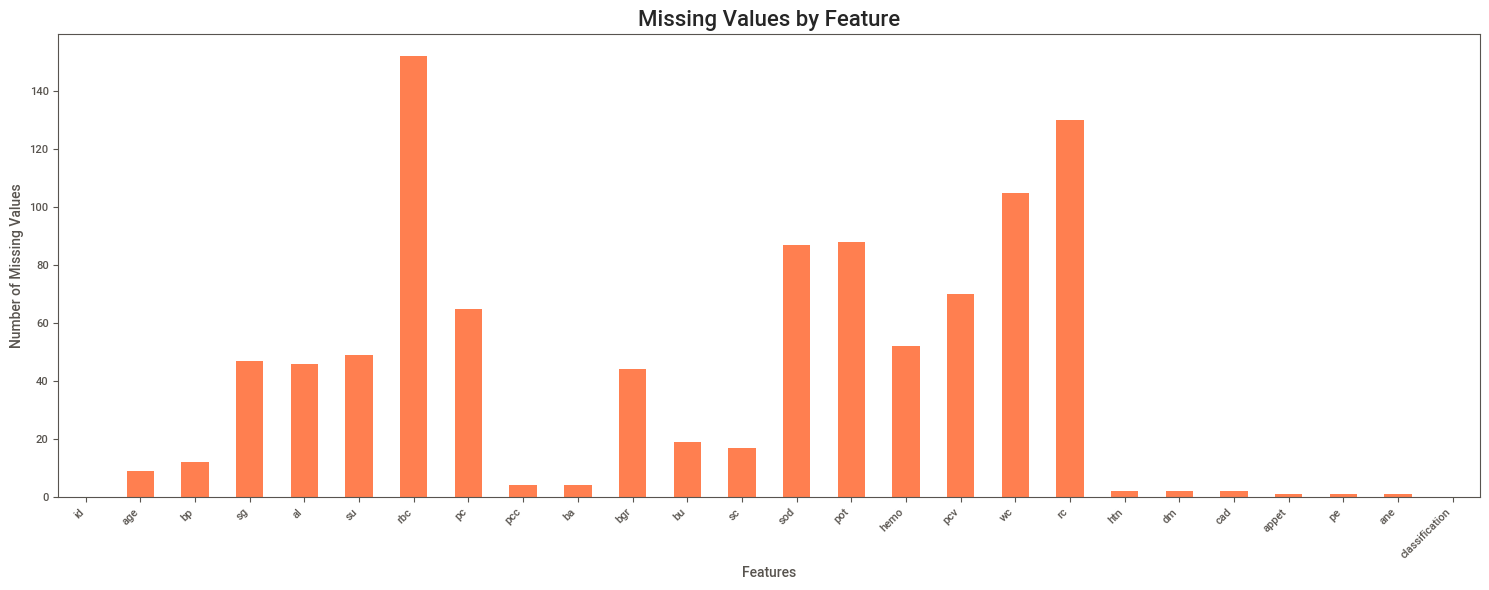


3. MISSING VALUES IMPUTATION STRATEGY
Numerical columns: ['id', 'age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo']
Categorical columns: ['rbc', 'pc', 'pcc', 'ba', 'pcv', 'wc', 'rc', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane', 'classification']

Imputing missing values...
Imputed age with median: 55.00
Imputed bp with median: 80.00
Imputed sg with median: 1.02
Imputed al with median: 0.00
Imputed su with median: 0.00
Imputed bgr with median: 121.00
Imputed bu with median: 42.00
Imputed sc with median: 1.30
Imputed sod with median: 138.00
Imputed pot with median: 4.40
Imputed hemo with median: 12.65
Imputed rbc with mode: normal
Imputed pc with mode: normal
Imputed pcc with mode: notpresent
Imputed ba with mode: notpresent
Imputed pcv with mode: 41
Imputed wc with mode: 9800
Imputed rc with mode: 5.2
Imputed htn with mode: no
Imputed dm with mode: no
Imputed cad with mode: no
Imputed appet with mode: good
Imputed pe with mode: no
Imputed ane with mode: no

4. OUTLIER 

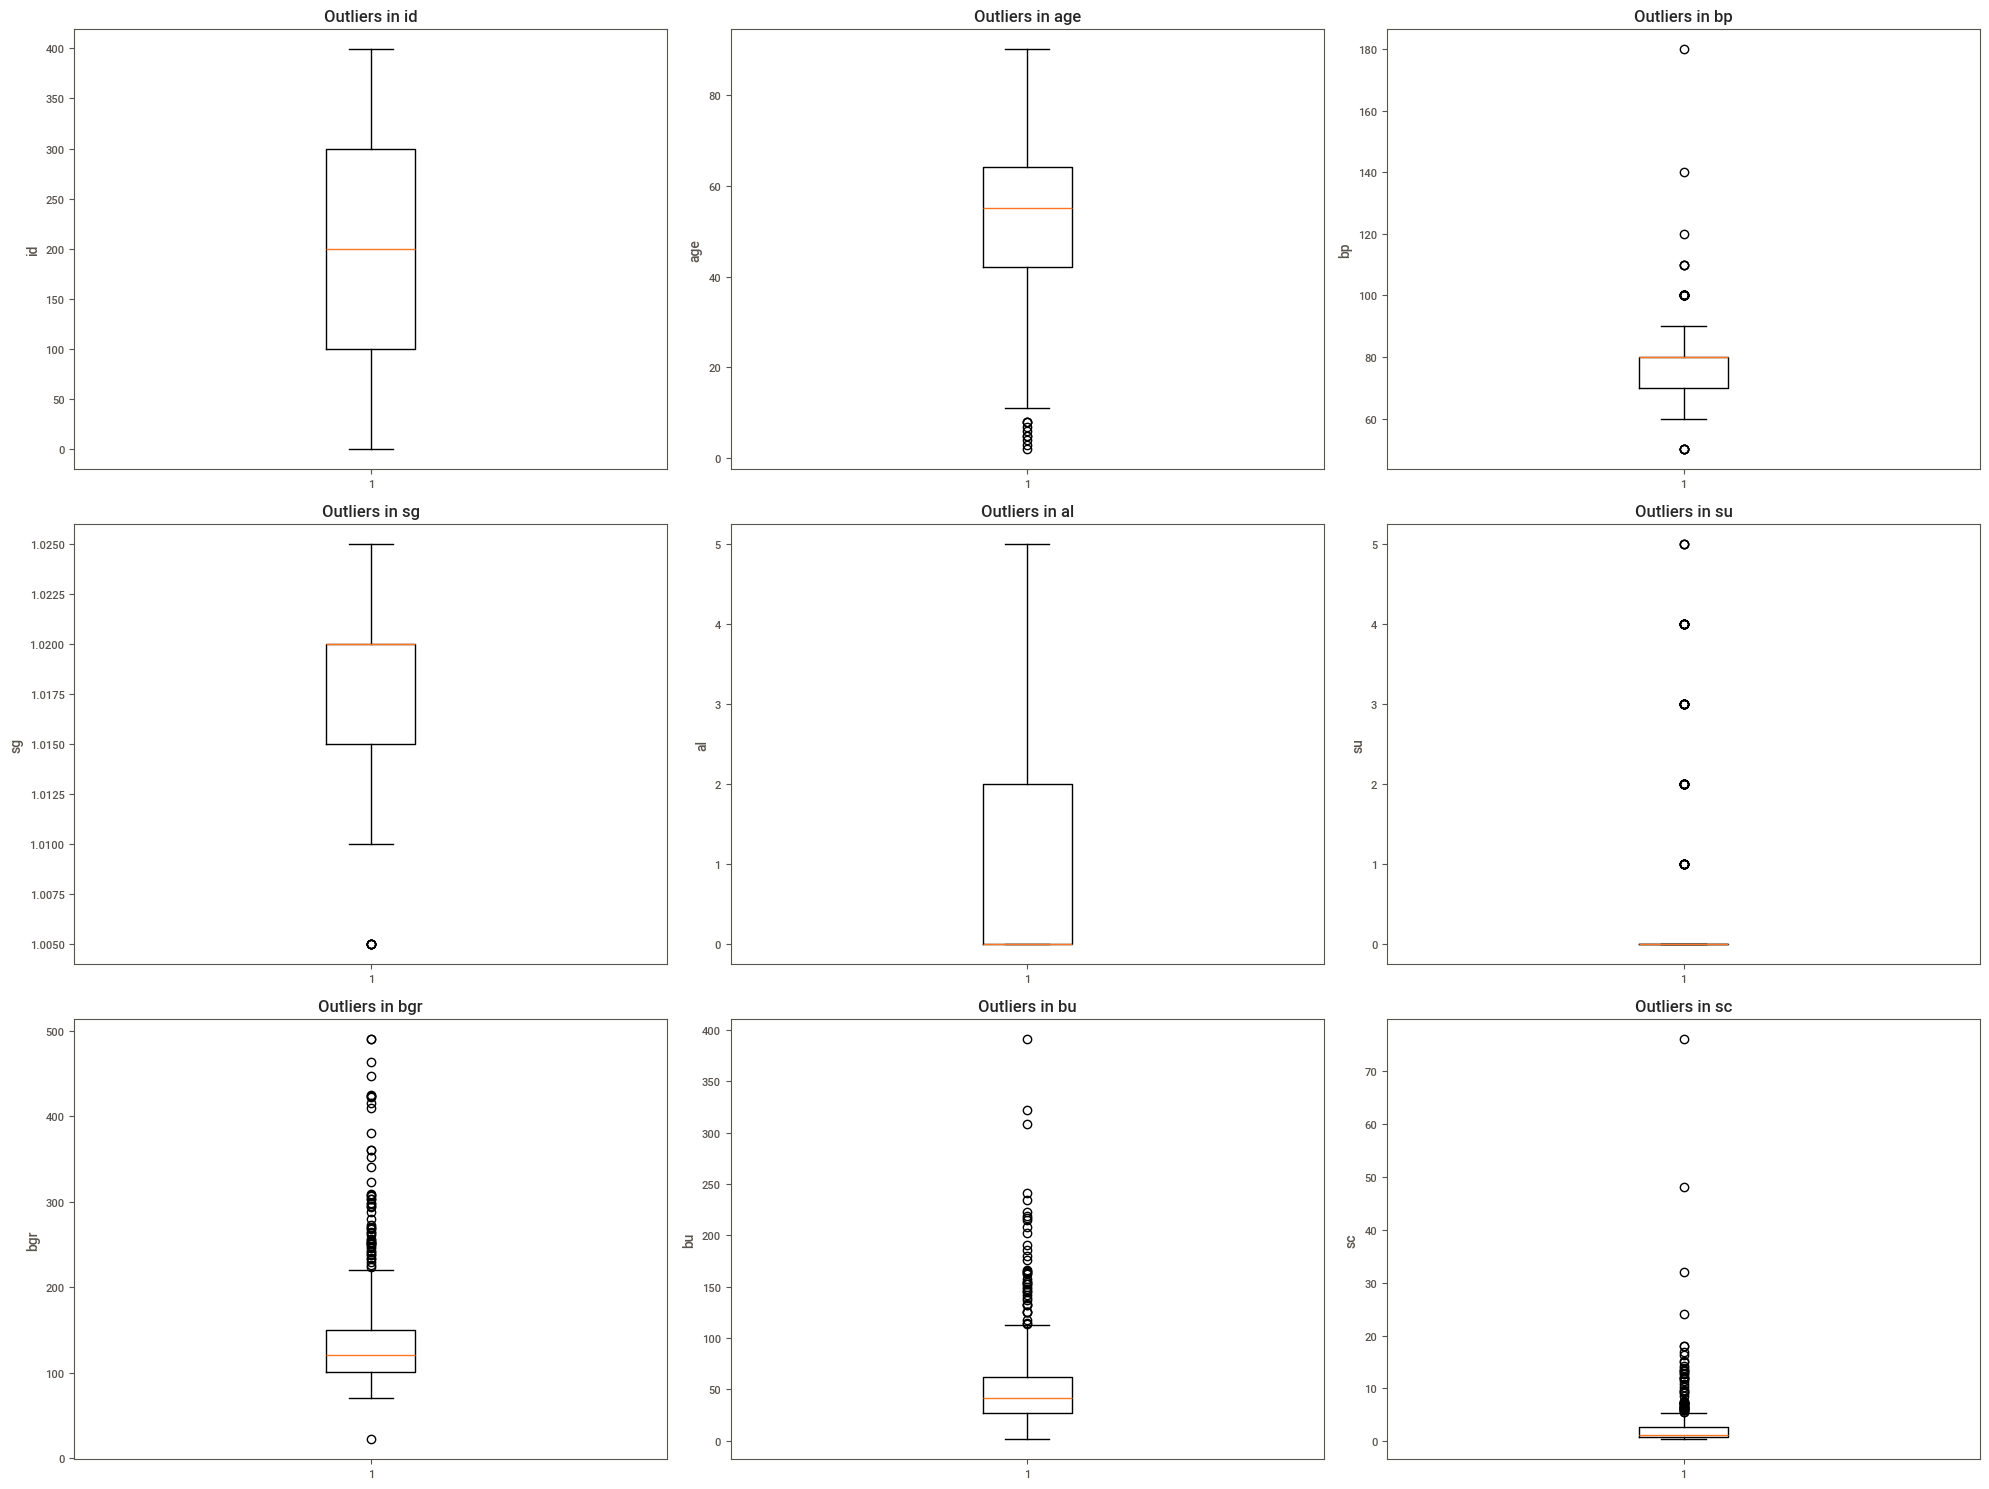


5. FEATURE ENGINEERING
Created age_group feature

6. CATEGORICAL ENCODING
Categorical columns to encode: ['rbc', 'pc', 'pcc', 'ba', 'pcv', 'wc', 'rc', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane']
Label encoded rbc
Label encoded pc
Label encoded pcc
Label encoded ba
Label encoded pcv
Label encoded wc
Label encoded rc
Label encoded htn
Label encoded dm
Label encoded cad
Label encoded appet
Label encoded pe
Label encoded ane

7. FINAL MISSING VALUES CLEANUP
Missing values after feature engineering:
Series([], dtype: int64)

8. DATA QUALITY CHECK AFTER PREPROCESSING
Final dataset shape: (400, 40)
Missing values after preprocessing: 0
Duplicate rows: 0

Final data types:
id                   int64
age                float64
bp                 float64
sg                 float64
al                 float64
su                 float64
rbc                 object
pc                  object
pcc                 object
ba                  object
bgr                float64
bu                 float64
sc 

In [54]:
# =============================================================================
# STEP 3: COMPREHENSIVE DATA PREPROCESSING (FIXED VERSION)
# =============================================================================

def comprehensive_preprocessing(df):
    print("=== COMPREHENSIVE DATA PREPROCESSING STARTED ===")
    
    # Create a copy to avoid modifying original data
    df_processed = df.copy()
    
    # 1. Data Type Analysis and Conversion
    print("\n1. DATA TYPE ANALYSIS AND CONVERSION")
    print("=" * 50)
    
    print("Original data types:")
    print(df_processed.dtypes)
    
    # Check for mixed data types in columns
    mixed_columns = []
    for col in df_processed.columns:
        if df_processed[col].dtype == 'object':
            # Check if it's actually numeric
            try:
                pd.to_numeric(df_processed[col], errors='raise')
                mixed_columns.append(col)
            except:
                pass
    
    print(f"\nColumns that might be numeric but are stored as object: {mixed_columns}")
    
    # Convert mixed columns to numeric
    for col in mixed_columns:
        df_processed[col] = pd.to_numeric(df_processed[col], errors='coerce')
        print(f"Converted {col} to numeric")
    
    # 2. Missing Values Analysis and Treatment
    print("\n2. MISSING VALUES ANALYSIS AND TREATMENT")
    print("=" * 50)
    
    # Analyze missing values
    missing_data = df_processed.isnull().sum()
    missing_percentage = (missing_data / len(df_processed) * 100).round(2)
    
    missing_summary = pd.DataFrame({
        'Missing Count': missing_data,
        'Missing Percentage': missing_percentage
    })
    
    print("Missing values summary:")
    print(missing_summary[missing_summary['Missing Count'] > 0])
    
    # Visualize missing values pattern
    plt.figure(figsize=(15, 6))
    missing_data.plot(kind='bar', color='coral')
    plt.title('Missing Values by Feature', fontsize=16, fontweight='bold')
    plt.xlabel('Features')
    plt.ylabel('Number of Missing Values')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # 3. Missing Values Imputation Strategy
    print("\n3. MISSING VALUES IMPUTATION STRATEGY")
    print("=" * 50)
    
    # Separate numerical and categorical columns
    numerical_cols = df_processed.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = df_processed.select_dtypes(include=['object']).columns.tolist()
    
    print(f"Numerical columns: {numerical_cols}")
    print(f"Categorical columns: {categorical_cols}")
    
    # Impute missing values
    print("\nImputing missing values...")
    
    # For numerical columns - use median (more robust than mean)
    for col in numerical_cols:
        if df_processed[col].isnull().sum() > 0:
            median_val = df_processed[col].median()
            df_processed[col].fillna(median_val, inplace=True)
            print(f"Imputed {col} with median: {median_val:.2f}")
    
    # For categorical columns - use mode
    for col in categorical_cols:
        if df_processed[col].isnull().sum() > 0:
            mode_val = df_processed[col].mode()[0]
            df_processed[col].fillna(mode_val, inplace=True)
            print(f"Imputed {col} with mode: {mode_val}")
    
    # 4. Outlier Detection and Treatment
    print("\n4. OUTLIER DETECTION AND TREATMENT")
    print("=" * 50)
    
    # Detect outliers using IQR method
    outlier_summary = {}
    
    for col in numerical_cols:
        Q1 = df_processed[col].quantile(0.25)
        Q3 = df_processed[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = df_processed[(df_processed[col] < lower_bound) | (df_processed[col] > upper_bound)]
        outlier_count = len(outliers)
        outlier_percentage = (outlier_count / len(df_processed)) * 100
        
        outlier_summary[col] = {
            'outlier_count': outlier_count,
            'outlier_percentage': outlier_percentage,
            'lower_bound': lower_bound,
            'upper_bound': upper_bound
        }
        
        print(f"{col}: {outlier_count} outliers ({outlier_percentage:.2f}%)")
    
    # Visualize outliers
    fig, axes = plt.subplots(3, 3, figsize=(20, 15))
    axes = axes.flatten()
    
    for i, col in enumerate(numerical_cols[:9]):
        # Box plot
        axes[i].boxplot(df_processed[col].dropna())
        axes[i].set_title(f'Outliers in {col}', fontweight='bold')
        axes[i].set_ylabel(col)
    
    # Hide empty subplots
    for i in range(len(numerical_cols[:9]), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # 5. Feature Engineering
    print("\n5. FEATURE ENGINEERING")
    print("=" * 50)
    
    # Create age groups
    if 'age' in df_processed.columns:
        df_processed['age_group'] = pd.cut(df_processed['age'], 
                                         bins=[0, 30, 50, 70, 100], 
                                         labels=['Young', 'Middle', 'Senior', 'Elderly'])
        print("Created age_group feature")
    
    # Create BMI categories if both height and weight are available
    if 'height' in df_processed.columns and 'weight' in df_processed.columns:
        # Calculate BMI (assuming height is in cm and weight is in kg)
        # Handle division by zero and invalid values
        height_clean = df_processed['height'].replace(0, np.nan)
        df_processed['bmi'] = df_processed['weight'] / ((height_clean / 100) ** 2)
        
        # Handle infinite values
        df_processed['bmi'] = df_processed['bmi'].replace([np.inf, -np.inf], np.nan)
        
        # Create BMI categories only for valid BMI values
        valid_bmi_mask = df_processed['bmi'].notna()
        if valid_bmi_mask.any():
            df_processed.loc[valid_bmi_mask, 'bmi_category'] = pd.cut(
                df_processed.loc[valid_bmi_mask, 'bmi'], 
                bins=[0, 18.5, 25, 30, 100], 
                labels=['Underweight', 'Normal', 'Overweight', 'Obese']
            )
        print("Created BMI and BMI category features")
    
    # 6. Categorical Encoding
    print("\n6. CATEGORICAL ENCODING")
    print("=" * 50)
    
    # Get updated categorical columns after preprocessing
    categorical_cols = df_processed.select_dtypes(include=['object']).columns.tolist()
    if 'classification' in categorical_cols:
        categorical_cols.remove('classification')  # Keep target as is
    
    print(f"Categorical columns to encode: {categorical_cols}")
    
    # Label encoding for categorical variables
    from sklearn.preprocessing import LabelEncoder
    
    label_encoders = {}
    for col in categorical_cols:
        le = LabelEncoder()
        df_processed[f'{col}_encoded'] = le.fit_transform(df_processed[col])
        label_encoders[col] = le
        print(f"Label encoded {col}")
    
    # 7. FINAL MISSING VALUES CLEANUP
    print("\n7. FINAL MISSING VALUES CLEANUP")
    print("=" * 50)
    
    # Check missing values after feature engineering
    missing_after_engineering = df_processed.isnull().sum()
    print("Missing values after feature engineering:")
    print(missing_after_engineering[missing_after_engineering > 0])
    
    # Handle missing values in engineered features
    for col in df_processed.columns:
        if df_processed[col].isnull().sum() > 0:
            if df_processed[col].dtype in ['object', 'category']:
                # For categorical features, fill with most common value
                mode_val = df_processed[col].mode()[0]
                df_processed[col].fillna(mode_val, inplace=True)
                print(f"Filled missing values in {col} with mode: {mode_val}")
            else:
                # For numerical features, fill with median
                median_val = df_processed[col].median()
                df_processed[col].fillna(median_val, inplace=True)
                print(f"Filled missing values in {col} with median: {median_val:.2f}")
    
    # 8. Data Quality Check After Preprocessing
    print("\n8. DATA QUALITY CHECK AFTER PREPROCESSING")
    print("=" * 50)
    
    print(f"Final dataset shape: {df_processed.shape}")
    print(f"Missing values after preprocessing: {df_processed.isnull().sum().sum()}")
    print(f"Duplicate rows: {df_processed.duplicated().sum()}")
    
    # Check data types after preprocessing
    print("\nFinal data types:")
    print(df_processed.dtypes)
    
    # 9. Prepare Features for Modeling
    print("\n9. PREPARE FEATURES FOR MODELING")
    print("=" * 50)
    
    # Select features for modeling (exclude original categorical columns, keep encoded ones)
    feature_columns = []
    
    # Add numerical columns
    numerical_cols_final = df_processed.select_dtypes(include=[np.number]).columns.tolist()
    feature_columns.extend(numerical_cols_final)
    
    # Add encoded categorical columns
    for col in categorical_cols:
        feature_columns.append(f'{col}_encoded')
    
    # Add engineered features (they should already be included in numerical_cols_final)
    # But let's make sure we have them
    engineered_features = ['age_group', 'bmi', 'bmi_category']
    for feature in engineered_features:
        if feature in df_processed.columns and feature not in feature_columns:
            feature_columns.append(feature)
    
    print(f"Selected features for modeling: {feature_columns}")
    print(f"Number of features: {len(feature_columns)}")
    
    # Create X (features) and y (target)
    X = df_processed[feature_columns].copy()
    y = df_processed['classification'].copy()
    
    # Encode target variable
    target_encoder = LabelEncoder()
    y_encoded = target_encoder.fit_transform(y)
    
    print(f"X shape: {X.shape}")
    print(f"y shape: {y_encoded.shape}")
    print(f"Target classes: {target_encoder.classes_}")
    print(f"Target distribution: {np.bincount(y_encoded)}")
    
    # Final verification
    print(f"\nFinal verification:")
    print(f"X missing values: {X.isnull().sum().sum()}")
    print(f"y missing values: {y.isnull().sum()}")
    
    return df_processed, X, y_encoded, feature_columns, label_encoders, target_encoder

# Run comprehensive preprocessing
df_processed, X, y, feature_columns, label_encoders, target_encoder = comprehensive_preprocessing(df_eda)